# Kickstarter Projects

## 目的
**プロジェクトのカテゴリや最終的に集めたい金額などからクラウドファンディングが成功するかどうかを予測する**

## Kaggle
https://www.kaggle.com/kemical/kickstarter-projects

# データセットの確認

## データの読み込み

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import datetime

In [3]:
# 定数の定義
random_state = 1234
test_size = 0.2
pd.options.display.precision = 2
tf.random.set_seed(random_state)

In [4]:
# 分析用データとして ks-projects-201801.csv のみを用いる
data = pd.read_csv('./ks-projects-201801.csv' )

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 各列の説明

参考) : <br>
https://kickstarternavi.jp/tips/196/<br>

https://help.kickstarter.com/hc/ja/articles/115005028514-Kickstarter-%E3%81%AE%E5%9F%BA%E6%9C%AC%E3%81%A8%E3%81%AF%E3%81%AA%E3%82%93%E3%81%A7%E3%81%99%E3%81%8B-

| 列名 | 説明 |
|:--:|:--:|
|　ID　|　識別番号　|
| name | クラウドファンディングのプロジェクト名 |
| category | カテゴリー |
| main_category | おおまかなカテゴリー |
| currency | 支援に必要な通貨 |
| deadline | クラウドファンディングの締め切り日 |
| goal | 集めたい金額 |
| launched | クラウドファンディングの開始日時 |
| pledged | 最終的に集まった支援金額 |
| state | 成功したかどうか　(今回の目的変数) |
| backers | 支援者の人数 |
| country | 募集側の国名 |
| usd pledged | 最終的に集まった支援金額(USドル, Kickstarterが掲載している金額) |
| usd_pledged_real | 最終的に集まった支援金額(USドル, Fixer.io APIによって計算した金額) |
| usd_goal_real | 集めたい金額(USドル) |

今回は成功するかどうかを予測するモデルを作りたいので，目的変数は **state** である．<br>
また予測はクラウドファンディングの募集開始前に行うので，
- pledged
- backers
- usd pledged
- usd_pledged_real

は説明変数として用いないものとする．

さらに
- IDはただの識別番号であり，予測に使用できるものではない点
- nameにも多くの情報は含まれているが，一つ一つが異なり扱いが非常に難しい点

からID, nameについても説明変数としては用いないものとする．

## 各列の代表値と欠損値

In [5]:
# 量的変数の代表値を表示
data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.79e+05,3.79e+05,3.79e+05,378661.00,3.75e+05,3.79e+05,3.79e+05
mean,1.07e+09,4.91e+04,9.68e+03,105.62,7.04e+03,9.06e+03,4.55e+04
std,6.19e+08,1.18e+06,9.56e+04,907.19,7.86e+04,9.10e+04,1.15e+06
min,5.97e+03,1.00e-02,0.00e+00,0.00,0.00e+00,0.00e+00,1.00e-02
25%,5.38e+08,2.00e+03,3.00e+01,2.00,1.70e+01,3.10e+01,2.00e+03
50%,1.08e+09,5.20e+03,6.20e+02,12.00,3.95e+02,6.24e+02,5.50e+03
75%,1.61e+09,1.60e+04,4.08e+03,56.00,3.03e+03,4.05e+03,1.55e+04
max,2.15e+09,1.00e+08,2.03e+07,219382.00,2.03e+07,2.03e+07,1.66e+08


In [6]:
# データ数の確認
data.shape

(378661, 15)

goalとusd_goal_realの最小値が1ドルを切っている． $\rightarrow$ 異常値の可能性があるので要確認<br>
goalの平均額が第三四分位数よりも大きくなっている． $\rightarrow$ goalの分布は高額なものがかなり少ないと予想

In [7]:
# dataの欠損値確認
data.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

上記から今回用いるデータには
- name
- usd pledged

の二つに欠損値があることがわかる．<br>
しかしnameとusd pledgedについては分析に利用しないため，欠損値の補完を行う必要はないと言える．

In [8]:
# dataから説明変数として用いない変数を消去
data.drop(['ID', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'], axis=1, inplace=True)

data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


In [9]:
# 再度dataの欠損値確認
data.isnull().sum()

name             4
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

dataから利用しない変数を削除すると欠損値がないことがわかる．(nameは説明変数の比較を行うために残してあるが，分析に直接使用することはないため，ここでは欠損値はないものとして考える)

# 変数の分布の可視化

ここでは変数の分布を可視化することで，異常値の探索とカテゴリ変数のカテゴリ数の削減を行う．

## 目的変数の分布の可視化

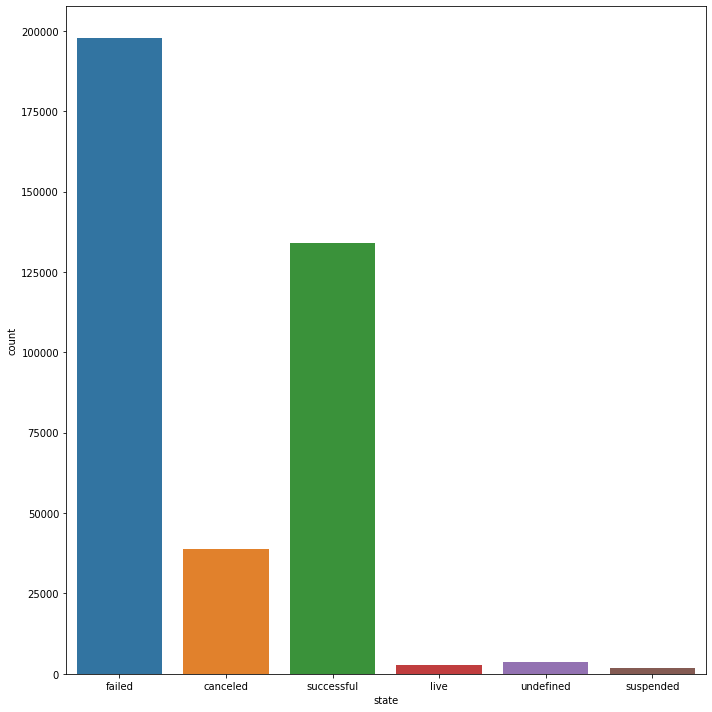

In [10]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

In [11]:
data['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [12]:
data_successful = data['state']=='successful'
print(f'クラウドファンディングの成功率 : {data_successful.sum() / data.shape[0]}')

クラウドファンディングの成功率 : 0.3537623362321443


In [13]:
data_live = data['state']=='live'
print(f'liveの割合 : {data_live.sum() / data.shape[0]}')
print(f'liveのデータ数 : {data_live.sum()}')

liveの割合 : 0.0073918359693763026
liveのデータ数 : 2799


In [14]:
data_failed = data['state']=='failed'
print(f'successful + failed : {(data_successful.sum() + data_failed.sum()) / data.shape[0]}')

successful + failed : 0.8759153966212523


クラウドファンディングの成功率は35.38%と，半分以上は成功していないことがわかる．<br>
successfulとfailedが全体の87.59%を占めていることがわかる．<br>
また，全体の0.74%を占めるliveはまだクラウドファンディングを行っているデータであることもわかる．<br>
今回はクラウドファンディングが成功するかどうかを予測したいので，liveは分析のデータから除外し，successful以外の4つのカテゴリについてはfailedとしてまとめて分析を行うものとする．

In [15]:
# stateがliveのデータをdata_live_onlyとして保持
data_live_only = data[data['state']=='live']
data_live_only = data_live_only.reset_index(drop=True)
data_live_only.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Unschooling To University Book Project,Nonfiction,Publishing,CAD,2018-01-19,3000.0,2017-11-20 18:15:14,live,CA,2396.36
1,KILOS.,Thrillers,Film & Video,USD,2018-02-06,5000.0,2017-12-23 20:34:31,live,US,5000.00
2,The Man in the Field,Horror,Film & Video,GBP,2018-01-08,850.0,2017-12-21 11:19:18,live,GB,1159.38
3,Dear Atlantas,Film & Video,Film & Video,USD,2018-02-16,2000.0,2017-12-18 02:48:27,live,US,2000.00
4,Art Calendar 2018,Illustration,Art,MXN,2018-01-06,1000.0,2017-12-21 05:34:12,live,MX,52.32


In [16]:
# live以外のデータ
data = data[data['state']!='live']
data = data.reset_index(drop=True)
data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


In [17]:
# dataのsuccessful以外のカテゴリをfailedに変更
data = data.replace({'canceled' : 'failed', 'undefined' : 'failed', 'suspended' : 'failed'})
data['state'].unique()

array(['failed', 'successful'], dtype=object)

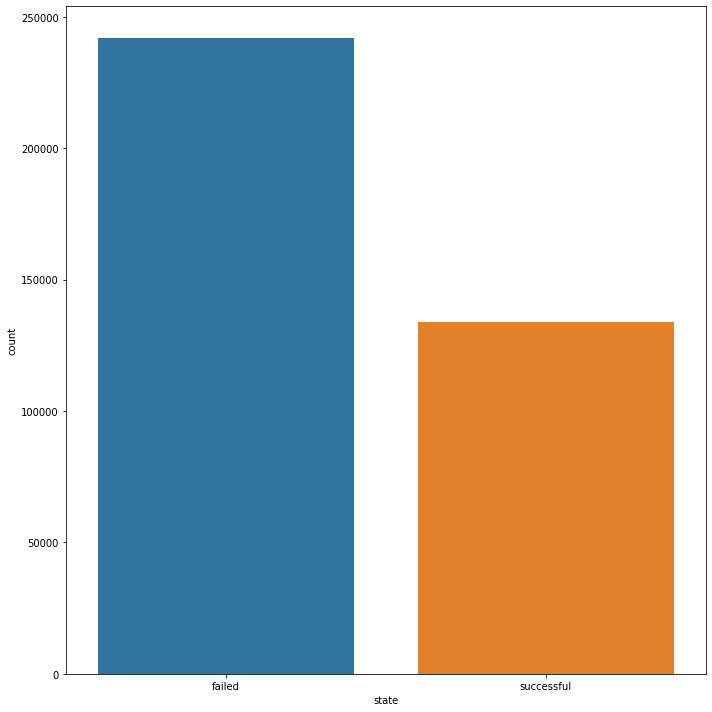

In [18]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

In [19]:
data_successful = data['state']=='successful'
print(f'クラウドファンディングの成功率 : {data_successful.sum() / data.shape[0]}')

クラウドファンディングの成功率 : 0.3563967626416078


## 説明変数の分布の可視化

### category

In [20]:
data['category'].value_counts()

Product Design     22077
Documentary        16082
Music              15647
Tabletop Games     14072
Shorts             12311
                   ...  
Residencies           69
Letterpress           48
Chiptune              35
Literary Spaces       23
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [21]:
print(sorted(set(data['category'])))

['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals', 'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture', 'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars', 'Camera Equipment', 'Candles', 'Ceramics', "Children's Books", 'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music', 'Comedy', 'Comic Books', 'Comics', 'Community Gardens', 'Conceptual Art', 'Cookbooks', 'Country & Folk', 'Couture', 'Crafts', 'Crochet', 'DIY', 'DIY Electronics', 'Dance', 'Design', 'Digital Art', 'Documentary', 'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events', 'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy', "Farmer's Markets", 'Farms', 'Fashion', 'Festivals', 'Fiction', 'Film & Video', 'Fine Art', 'Flight', 'Food', 'Food Trucks', 'Footwear', 'Gadgets', 'Games', 'Gaming Hardware', 'Glass', 'Graphic Design', 'Graphic Novels', 'Hardware', 'Hip-Hop', 'Horror', 'Illustration', 'Immersive', 'Indie Rock', 'Installations', 'Interactive Design', 'Jazz', 

この変数にはPrintとPrintingというよく似たカテゴリがある．<br>
これらに違いがないのであればまとめた方が良さそうなので，二つのカテゴリのデータを比較してみる．

In [22]:
# print
data_print = data[data['category']=='Print']
print(f'全要素数 : {len(data_print)}')
data_print_Jour = data_print[data_print['main_category']=='Journalism']
print(f'main_categoryがJournalismの要素数 : {len(data_print_Jour)}')
data_print.head(10)

全要素数 : 724
main_categoryがJournalismの要素数 : 724


,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
302,The Book of Maxwell,Print,Journalism,USD,2017-08-07,1500.0,2017-07-12 23:47:37,successful,US,1500.00
620,How I Got Beat-Up By The FBI When I Was Four Y...,Print,Journalism,USD,2014-12-19,160.0,2014-11-19 16:58:47,failed,US,160.00
1516,The Life Story Project,Print,Journalism,USD,2014-11-03,2500.0,2014-10-04 03:14:42,failed,US,2500.00
1700,The Happy Newspaper,Print,Journalism,GBP,2015-10-08,500.0,2015-09-08 17:55:20,successful,GB,766.98
2052,descubriendo.me,Print,Journalism,EUR,2015-09-05,99000.0,2015-07-11 11:04:51,failed,ES,111553.07
2515,¡Derecho A La Vivienda!/A Right to Housing! Bu...,Print,Journalism,USD,2015-06-09,1000.0,2015-05-27 23:40:33,successful,US,1000.00
2799,THE HUNT FOR A WITCH WITH LYME DISEASE,Print,Journalism,USD,2014-07-25,3000.0,2014-06-25 19:59:47,failed,US,3000.00
6304,Save Me From This Upcoming Election,Print,Journalism,USD,2016-11-26,500000.0,2016-09-27 05:57:05,failed,US,500000.00
6654,"The Love, lost and Found",Print,Journalism,USD,2016-07-29,2500.0,2016-06-29 00:05:45,failed,US,2500.00
6791,NYT Ad Challenging John Roberts to File in His...,Print,Journalism,USD,2015-02-02,60000.0,2015-01-03 00:41:25,failed,US,60000.00


In [23]:
# printing
data_printing = data[data['category']=='Printing']
print(f'全要素数 : {len(data_printing)}')
data_printing_Craf = data_printing[data_printing['main_category']=='Crafts']
print(f'main_categoryがCraftsの要素数 : {len(data_printing_Craf)}')
data_printing.head(10)

全要素数 : 236
main_categoryがCraftsの要素数 : 236


,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
3684,Non-profit start up: merchandise fundraiser,Printing,Crafts,USD,2016-08-02,1100.0,2016-06-03 23:25:51,failed,US,1100.00
5167,Feltmeupdesigns Rainbow Doodle Birds Printed T...,Printing,Crafts,GBP,2015-06-25,850.0,2015-05-26 18:54:07,successful,GB,1336.75
5868,Draw & ScreenPrint fluorescent colors on stree...,Printing,Crafts,EUR,2015-01-10,900.0,2014-12-11 11:47:58,failed,NL,1042.92
6860,One-verse-theater,Printing,Crafts,SEK,2017-06-09,9000.0,2017-05-10 14:51:35,failed,SE,1030.42
7807,The Clock That Make Seasons Come Together,Printing,Crafts,USD,2015-06-08,5550.0,2015-05-09 23:54:30,failed,US,5550.00
8055,Year Round Co. Home Textile Product Launch,Printing,Crafts,USD,2015-04-08,4500.0,2015-03-09 16:53:31,successful,US,4500.00
8092,Kreative Flash Kards,Printing,Crafts,USD,2015-08-28,5890.0,2015-08-07 22:48:12,failed,US,5890.00
8769,Manos: The Shirts of Fate,Printing,Crafts,USD,2014-09-01,250.0,2014-07-18 14:53:30,successful,US,250.00
9483,boxity - decorative storage resembling city bu...,Printing,Crafts,DKK,2014-12-20,15000.0,2014-11-10 19:19:20,failed,DK,2463.62
13994,the button is here. go out with your flair out...,Printing,Crafts,USD,2015-05-05,5000.0,2015-04-20 20:14:03,failed,US,5000.00


上記からPrintとPrintingはmain_categoryに違いがあり，
- PrintはJournalismで書籍などの出版
- PrintingはCraftsで服やクッションなどへの絵などのプリント

というように大きな違いがあった．<br>
よってまとめるのではなく別のものとして扱った方が良いだろう・

In [24]:
# もともとOtherのカテゴリがないかを確認
print(sum(data['category']=='Other'))

0


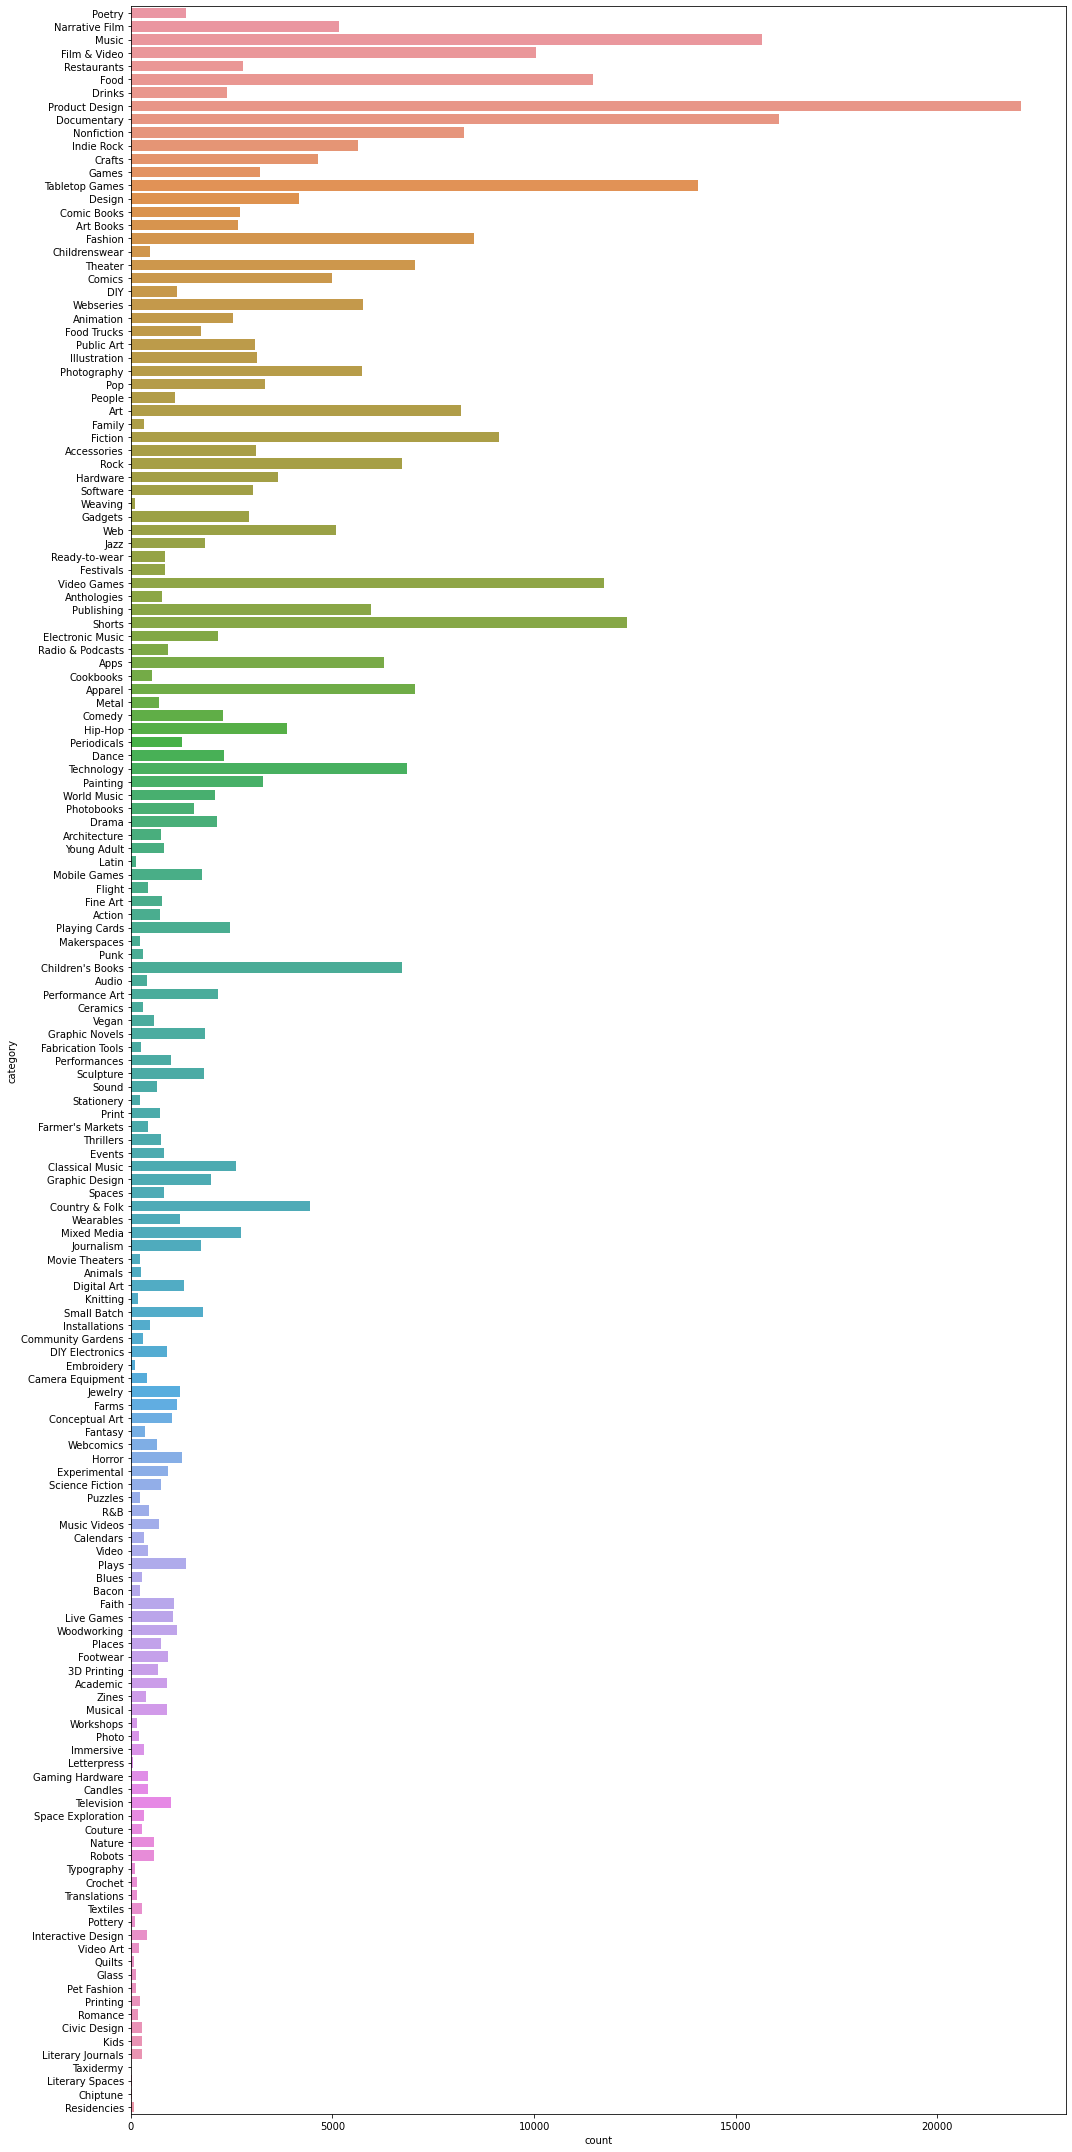

In [25]:
plt.figure(figsize=(15,30))
sns.countplot(y='category', data=data)
plt.tight_layout()

category,Chiptune,Residencies,Anthologies,Dance,Letterpress,Indie Rock,Country & Folk,Classical Music,Theater,Performances,...,Hip-Hop,Television,Action,Candles,Food Trucks,Software,Video,Web,Mobile Games,Apps
state,,,,,,,,,,,,,,,,,,,,,
failed,0.23,0.28,0.33,0.33,0.35,0.36,0.37,0.37,0.38,0.38,...,0.84,0.84,0.85,0.87,0.87,0.88,0.88,0.91,0.91,0.94
successful,0.77,0.72,0.67,0.67,0.65,0.64,0.63,0.63,0.62,0.62,...,0.16,0.16,0.15,0.13,0.13,0.12,0.12,0.09,0.09,0.06


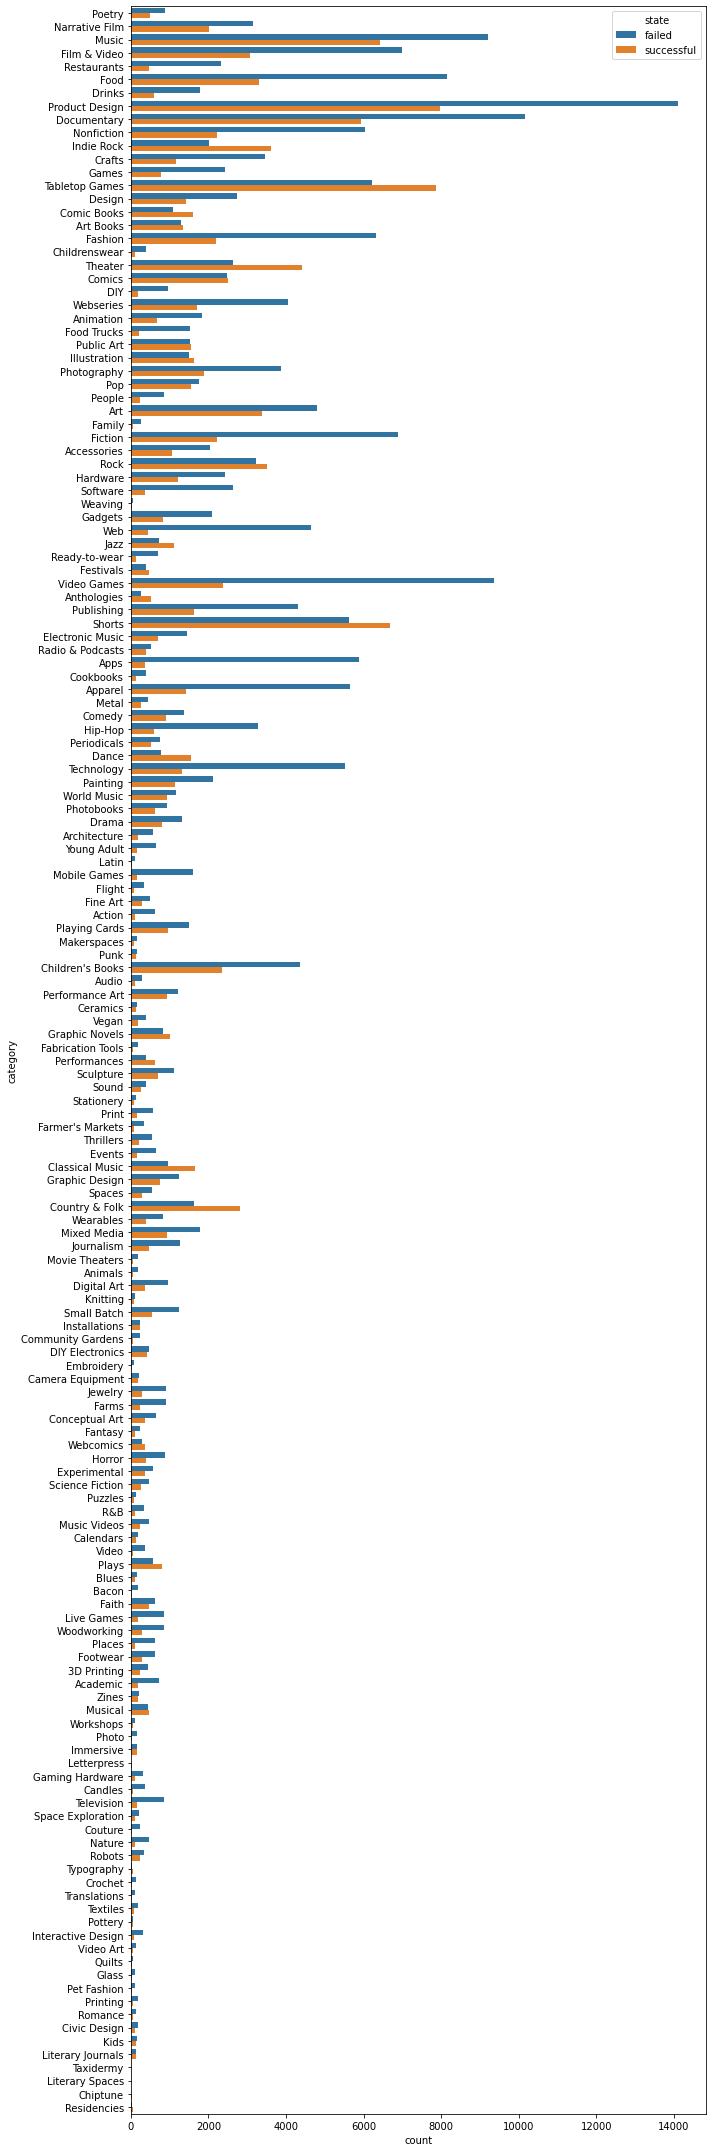

In [26]:
# categoryとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['category'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(10,30))
sns.countplot(y='category', hue='state', data=data)
plt.tight_layout()

In [27]:
data_category = data['category'].value_counts()
data_category = pd.DataFrame(data_category)

print('categoryの出現回数が3000回より多いカテゴリ数')
print(sum(data_category['category'] > 3000))
print('categoryの出現回数が3000回より多いデータの割合')
print(data_category[data_category['category'] > 3000].sum()[0] / data.shape[0])
print('categoryの出現回数が3000回以下のデータ数')
print(data_category[data_category['category'] <= 3000].sum()[0])

categoryの出現回数が3000回より多いカテゴリ数
37
categoryの出現回数が3000回より多いデータの割合
0.7168109572130197
categoryの出現回数が3000回以下のデータ数
106440


In [28]:
# 出現回数が3000回以下のデータを収集
data_cat_3000 = data['category'].value_counts()<=3000
data_cat_3000 = pd.DataFrame(data_cat_3000)
data_cat_3000 = data_cat_3000[data_cat_3000['category']==True]
print(sorted(set(data_cat_3000.index)))

['3D Printing', 'Academic', 'Action', 'Animals', 'Animation', 'Anthologies', 'Architecture', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars', 'Camera Equipment', 'Candles', 'Ceramics', 'Childrenswear', 'Chiptune', 'Civic Design', 'Classical Music', 'Comedy', 'Comic Books', 'Community Gardens', 'Conceptual Art', 'Cookbooks', 'Couture', 'Crochet', 'DIY', 'DIY Electronics', 'Dance', 'Digital Art', 'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events', 'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy', "Farmer's Markets", 'Farms', 'Festivals', 'Fine Art', 'Flight', 'Food Trucks', 'Footwear', 'Gadgets', 'Gaming Hardware', 'Glass', 'Graphic Design', 'Graphic Novels', 'Horror', 'Immersive', 'Installations', 'Interactive Design', 'Jazz', 'Jewelry', 'Journalism', 'Kids', 'Knitting', 'Latin', 'Letterpress', 'Literary Journals', 'Literary Spaces', 'Live Games', 'Makerspaces', 'Metal', 'Mixed Media', 'Mobile Games', 'Movie Theaters', 'Music Videos', 'Musical', 'Nature',

categoryはmian_categoryをより詳しく分類したもので，159種類ある．<br>
このまま用いるとカテゴリ数が多く，各カテゴリの出現回数にはばらつきがあるため，出現頻度の少ないカテゴリをまとめてしまいたい．<br>
そこで出現回数が3000回より多いカテゴリはそのまま用いて，3000回以下のカテゴリをまとめることを考える．<br>
出現回数が3000回以下のカテゴリとしたのは，出現回数が3000回というのは出現頻度が全体の1%以下だからである．<br>
この場合全体の28.32%がその他に分類されることになり，カテゴリ数を1/4程度に減らすことができる．<br>
しかし，この基準でカテゴリを削減すると成功率の高いChiptuneやResidenciesなどのカテゴリがまとめられて失われてしまう．<br>
更にまとめられたカテゴリのデータ数は10万以上あり，まとめられたカテゴリのデータ数が他のカテゴリより多くなってしまう．<br>
今回は計算量は増えるが特徴量を減らさずに分析を行う．

以下は3000回以下のデータをOtherとしてまとめる際に用いたコードである．<br>
学習結果によっては再度使用する可能性があるため，保存しておく．

In [29]:
'''
# 出現回数が3000回以下のカテゴリを'Other'に変換
for j in range(len(data)):
    for i in range(len(data_cat_3000)):
        if data_cat_3000.index[i] == data['category'][j]:
            data['category'][j] = 'Other'
data.head()
'''

"\n# 出現回数が3000回以下のカテゴリを'Other'に変換\nfor j in range(len(data)):\n    for i in range(len(data_cat_3000)):\n        if data_cat_3000.index[i] == data['category'][j]:\n            data['category'][j] = 'Other'\ndata.head()\n"

In [30]:
'''
# 出現回数3000回以上の37のカテゴリと'Other'を合わせてカテゴリの数が38になっているかの確認
len(data['category'].unique())
'''

"\n# 出現回数3000回以上の37のカテゴリと'Other'を合わせてカテゴリの数が38になっているかの確認\nlen(data['category'].unique())\n"

In [31]:
'''
plt.figure(figsize=(15,10))
sns.countplot(x='category', data=data)
plt.tight_layout()
'''

"\nplt.figure(figsize=(15,10))\nsns.countplot(x='category', data=data)\nplt.tight_layout()\n"

### main_category

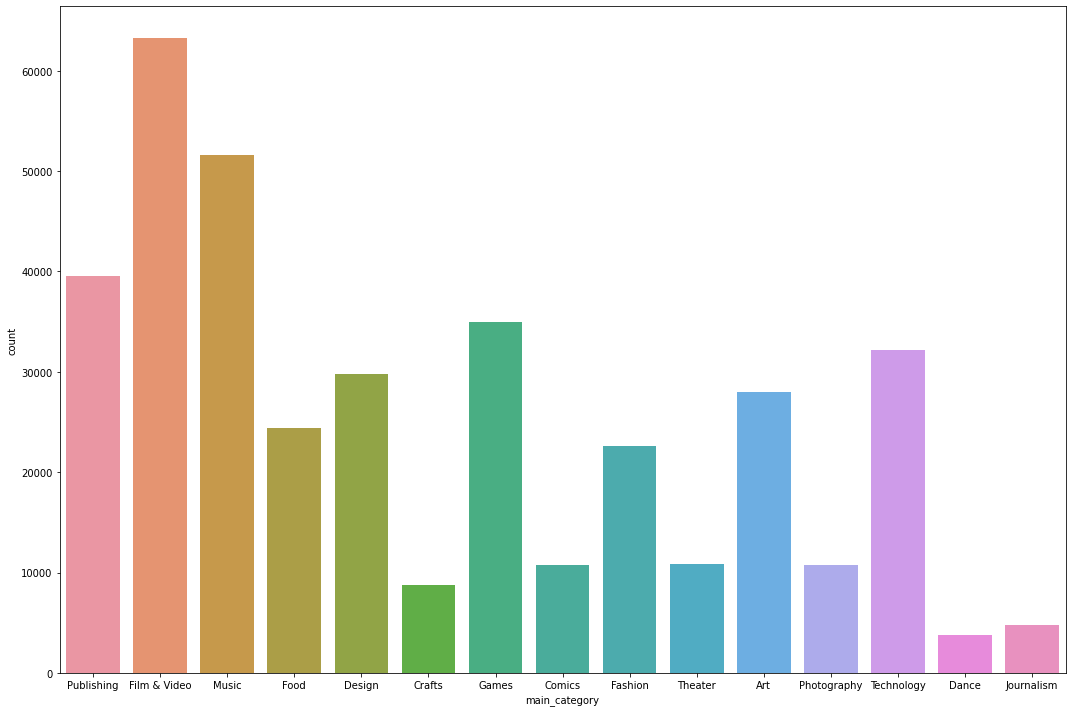

In [32]:
plt.figure(figsize=(15,10))
sns.countplot(x='main_category', data=data)
plt.tight_layout()

main_category,Dance,Theater,Comics,Music,Art,Film & Video,Games,All,Design,Publishing,Photography,Food,Fashion,Crafts,Journalism,Technology
state,,,,,,,,,,,,,,,,
failed,0.38,0.4,0.46,0.53,0.59,0.63,0.64,0.64,0.65,0.69,0.69,0.75,0.75,0.76,0.79,0.8
successful,0.62,0.6,0.54,0.47,0.41,0.37,0.36,0.36,0.35,0.31,0.31,0.25,0.25,0.24,0.21,0.2


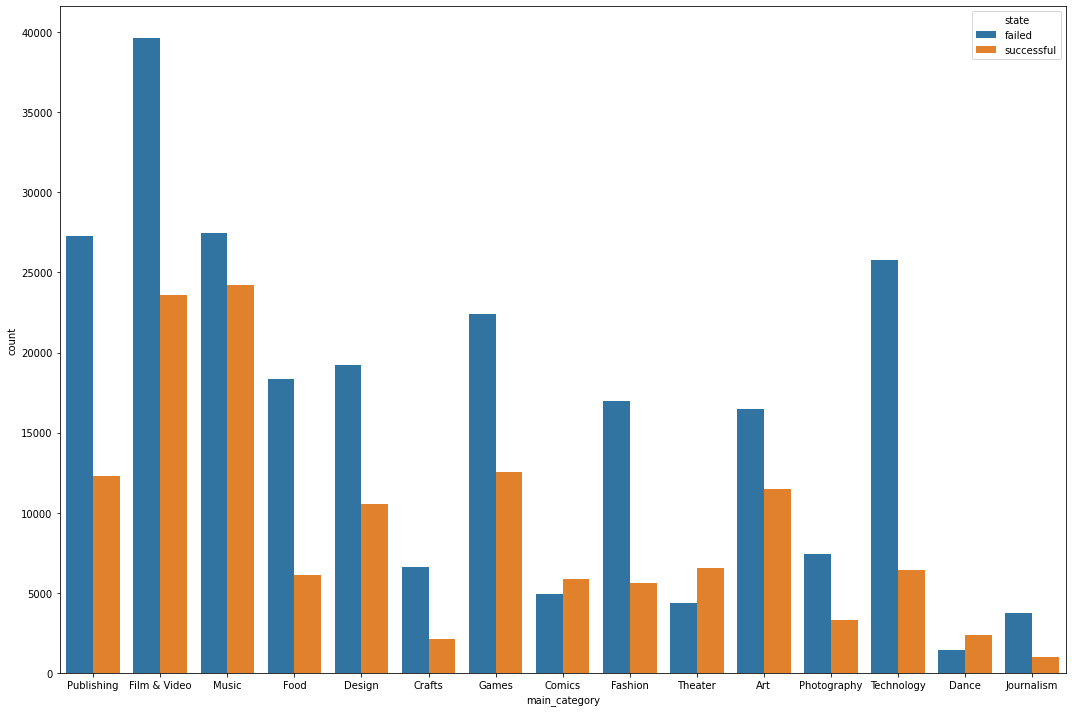

In [33]:
# main_categoryとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['main_category'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15,10))
sns.countplot(x='main_category', hue='state', data=data)
plt.tight_layout()

In [34]:
data['main_category'].value_counts()

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

main_categoryは15種類存在する．<br>
カテゴリごとの数にばらつきはあるが，どのカテゴリも一定程度のデータ数を有しているのでmain_category変数はこのまま使用する．

### currency

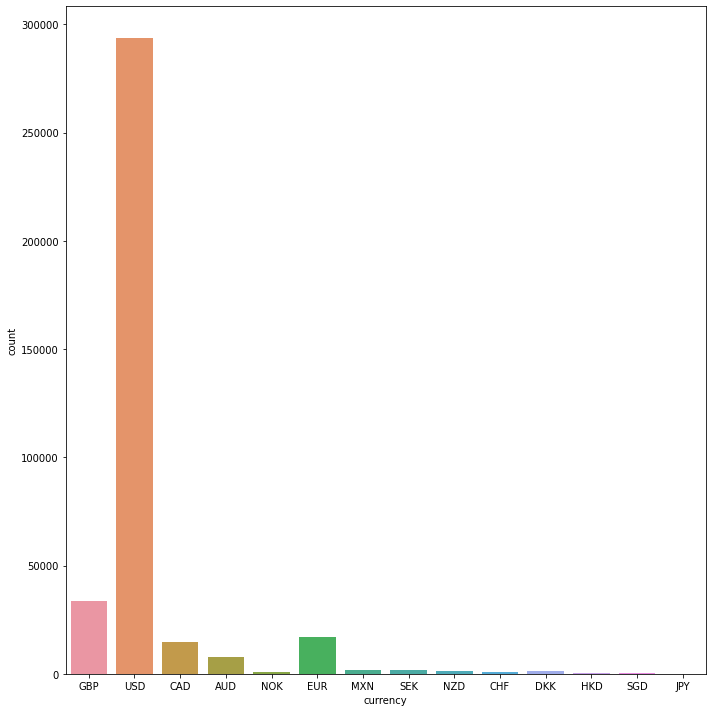

In [35]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

currency,USD,HKD,GBP,All,SGD,DKK,NZD,SEK,CAD,AUD,CHF,MXN,NOK,EUR,JPY
state,,,,,,,,,,,,,,,
failed,0.63,0.63,0.64,0.64,0.66,0.67,0.69,0.71,0.72,0.74,0.75,0.76,0.77,0.77,0.77
successful,0.37,0.37,0.36,0.36,0.34,0.33,0.31,0.29,0.28,0.26,0.25,0.24,0.23,0.23,0.23


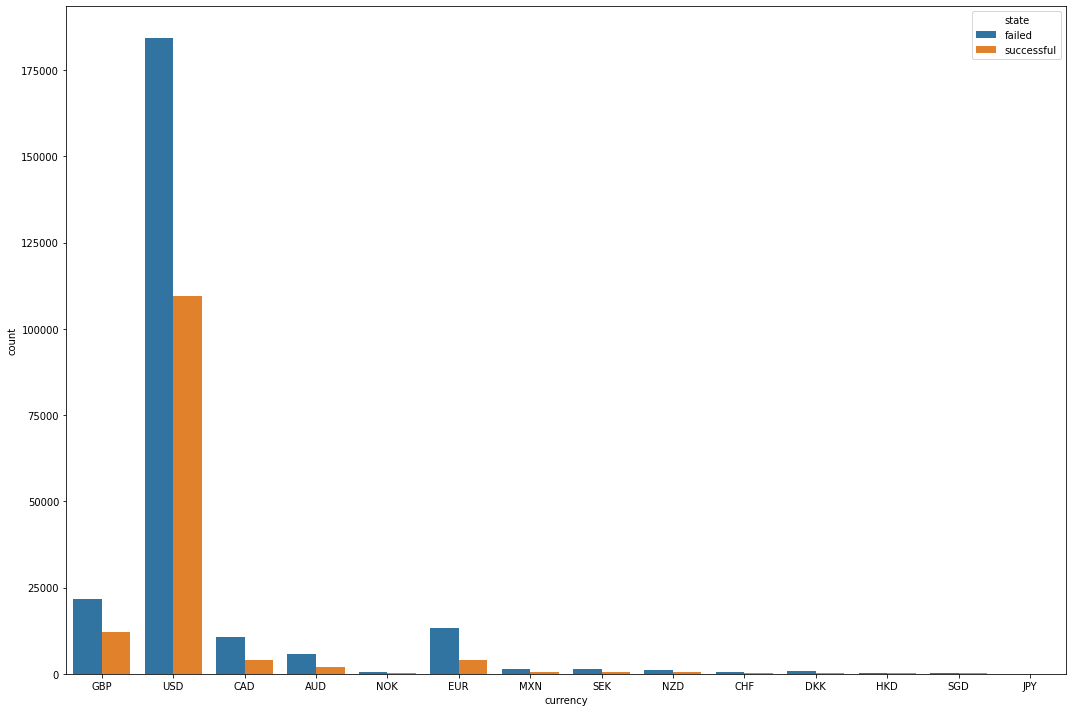

In [36]:
# currencyとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['currency'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15,10))
sns.countplot(x='currency', hue='state', data=data)
plt.tight_layout()

In [37]:
data['currency'].value_counts()

USD    293624
GBP     33853
EUR     17076
CAD     14830
AUD      7880
SEK      1768
MXN      1645
NZD      1464
DKK      1113
CHF       754
NOK       714
HKD       583
SGD       527
JPY        31
Name: currency, dtype: int64

In [38]:
data_USD = data['currency']=='USD'
print(f'USDの割合 : {data_USD.sum() / data.shape[0]}')

USDの割合 : 0.7812016112296535


In [39]:
data_GBP = data['currency']=='GBP'
data_EUR = data['currency']=='EUR'
data_CAD = data['currency']=='CAD'
data_AUD = data['currency']=='AUD'
print(f'USD, GBP, EUR, CAD, AUDが占める割合 : {(data_USD.sum() + data_GBP.sum() + data_EUR.sum() + data_CAD.sum() + data_AUD.sum()) / data.shape[0]}')

USD, GBP, EUR, CAD, AUDが占める割合 : 0.9771219224076921


currencyの分布からクラウドファンディングで使用される通貨の78%はUSDであることがわかる．<br>
またUSD, GBP, EUR, CAD, AUDで全体の97.71%を占めている.<br>
更に通貨の違いによる成功率には大きな違いは見られなかった．<br>
異常のことからその他の通貨に関してはcur_otherでまとめて扱うものとする．

In [40]:
# USD, GBP, EUR, CAD, AUD以外をcur_otherに書き換える
data = data.replace({'NOK' : 'cur_other', 'MXN' : 'cur_other', 'SEK' : 'cur_other', 'NZD' : 'cur_other', 'CHF' : 'cur_other', 'DKK' : 'cur_other', 'HKD' : 'cur_other', 'SGD' : 'cur_other', 'JPY' : 'cur_other'})
data['currency'].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'cur_other', 'EUR'], dtype=object)

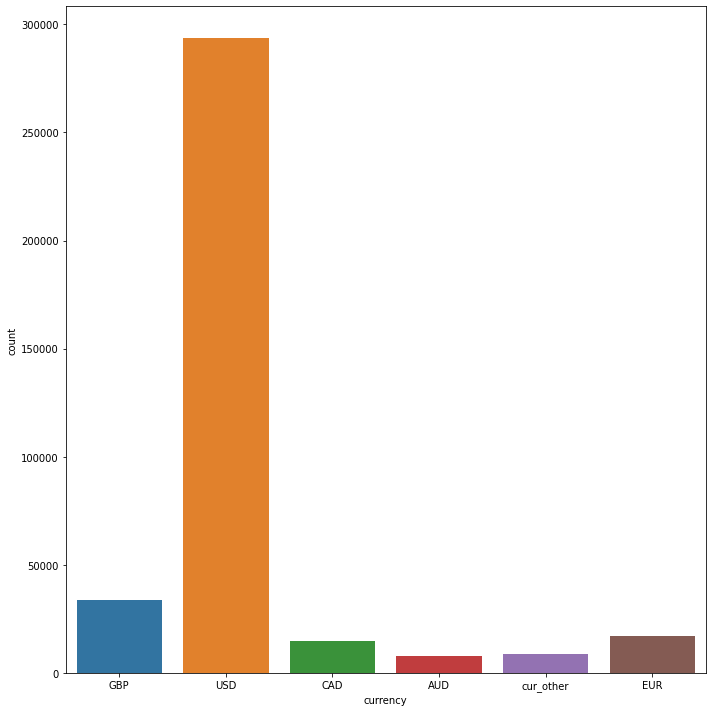

In [41]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

currency,USD,GBP,All,cur_other,CAD,AUD,EUR
state,,,,,,,
failed,0.63,0.64,0.64,0.71,0.72,0.74,0.77
successful,0.37,0.36,0.36,0.29,0.28,0.26,0.23


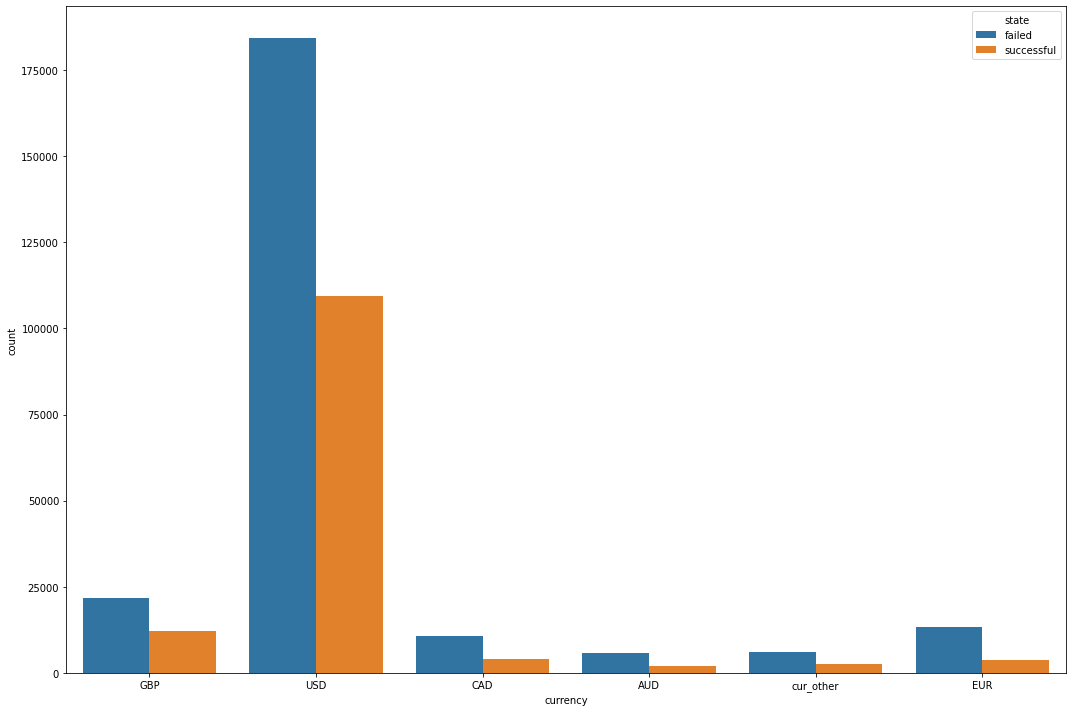

In [42]:
# currencyとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['currency'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15,10))
sns.countplot(x='currency', hue='state', data=data)
plt.tight_layout()

### country

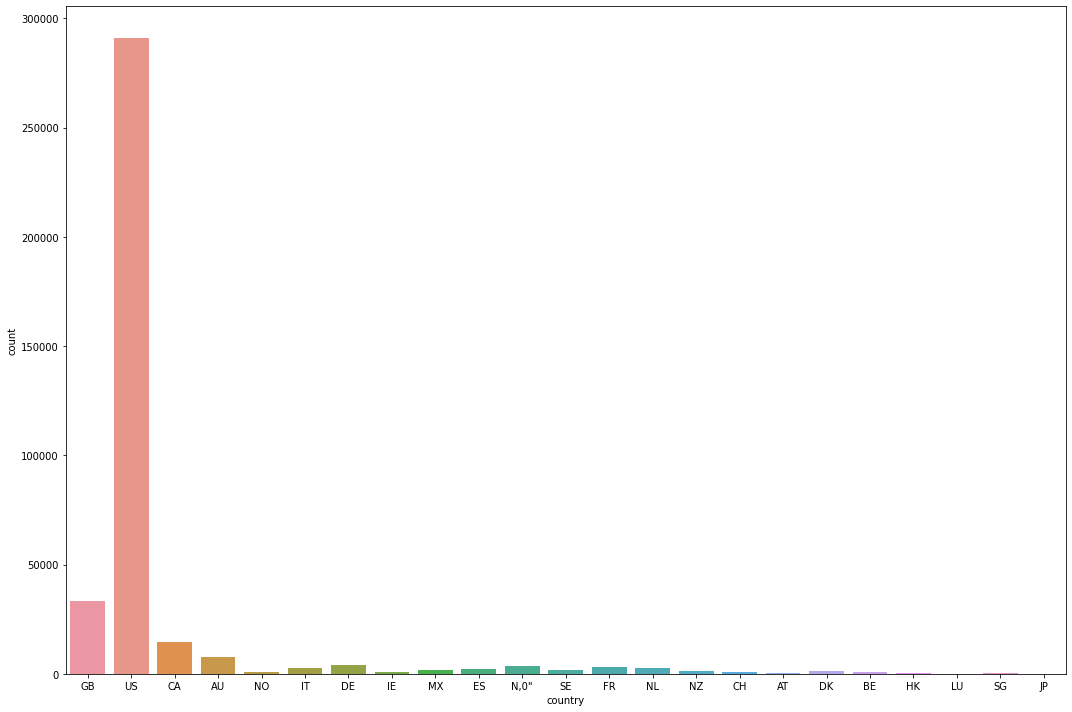

In [43]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

country,US,HK,GB,All,SG,DK,FR,NZ,LU,SE,...,CH,MX,NO,DE,JP,ES,NL,AT,IT,"N,0"""
state,,,,,,,,,,,,,,,,,,,,,
failed,0.62,0.63,0.64,0.64,0.66,0.67,0.69,0.69,0.69,0.71,...,0.75,0.76,0.77,0.77,0.77,0.78,0.78,0.82,0.84,0.97
successful,0.38,0.37,0.36,0.36,0.34,0.33,0.31,0.31,0.31,0.29,...,0.25,0.24,0.23,0.23,0.23,0.22,0.22,0.18,0.16,0.03


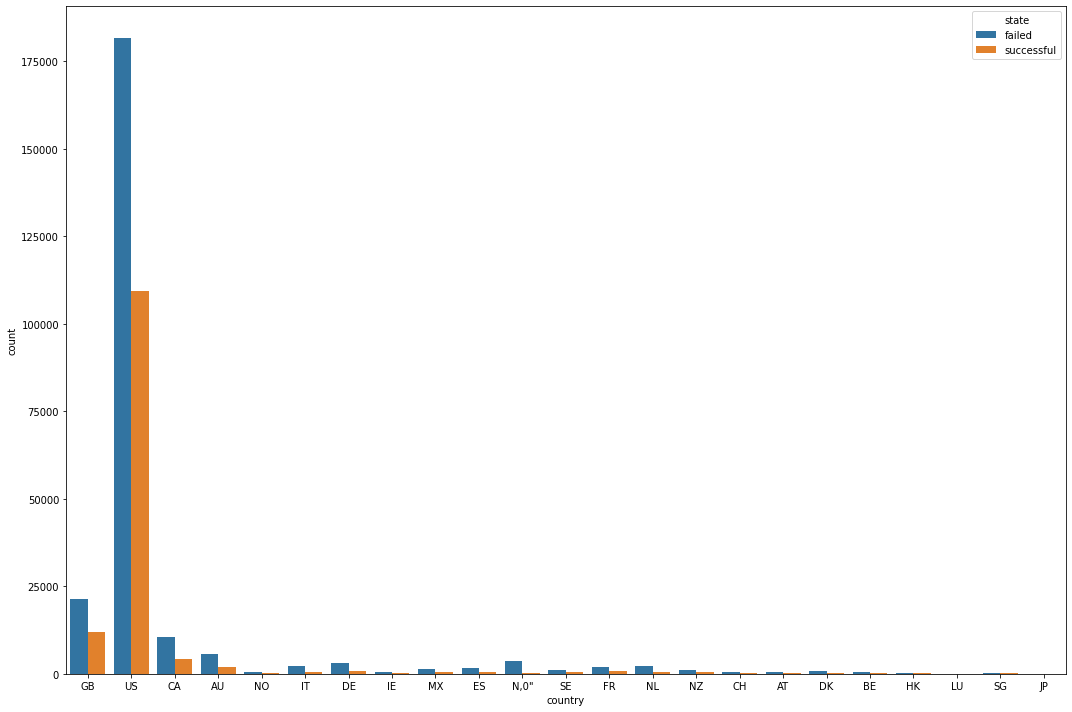

In [44]:
# countryとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['country'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15,10))
sns.countplot(x='country', hue='state', data=data)
plt.tight_layout()

In [45]:
data['country'].value_counts()

US      290887
GB       33393
CA       14624
AU        7769
DE        4096
N,0"      3796
FR        2887
NL        2833
IT        2802
ES        2224
SE        1737
MX        1645
NZ        1436
DK        1097
IE         800
CH         747
NO         700
BE         605
HK         583
AT         582
SG         527
LU          61
JP          31
Name: country, dtype: int64

In [46]:
data_US = data['country']=='US'
print(f'USの割合 : {data_US.sum() / data.shape[0]}')

USの割合 : 0.7739196832880153


In [47]:
data_GB = data['country']=='GB'
data_CA = data['country']=='CA'
data_AU = data['country']=='AU'
print(f'US + GB + CA + AUの割合 : {(data_US.sum() + data_GB.sum() + data_CA.sum() + data_AU.sum()) / data.shape[0]}')

US + GB + CA + AUの割合 : 0.9223411784112254


USでの募集が全体の77.39%を占めている．<br>
この変数は

In [48]:
# US, GB, CA, AU以外をcou_otherに書き換える
data = data.replace({'NO' : 'cou_other', 'IT' : 'cou_other', 'DE' : 'cou_other', 'IE' : 'cou_other', 'MX' : 'cou_other', 'ES' : 'cou_other', 'N,0"' : 'cou_other', 'SE' : 'cou_other', 'FR' : 'cou_other', 'NL' : 'cou_other', 'NZ' : 'cou_other', 'CH' : 'cou_other', 'AT' : 'cou_other', 'DK' : 'cou_other', 'BE' : 'cou_other', 'HK' : 'cou_other', 'LU' : 'cou_other', 'SG' : 'cou_other', 'JP' : 'cou_other'})
data['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'cou_other'], dtype=object)

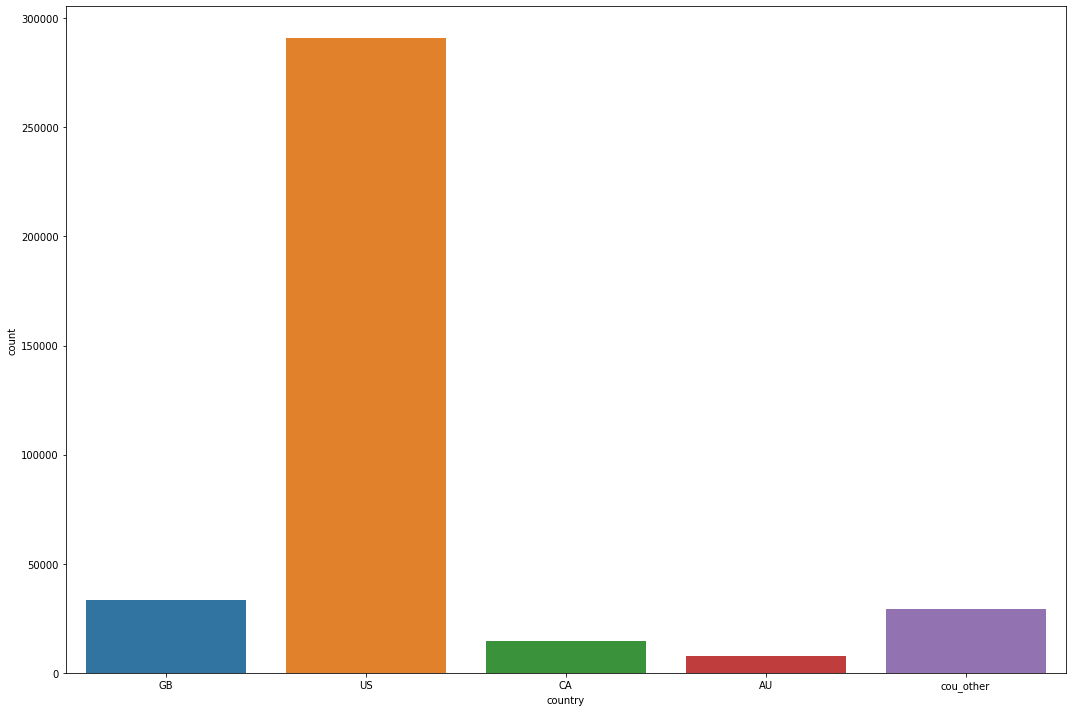

In [49]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

country,US,GB,All,CA,AU,cou_other
state,,,,,,
failed,0.62,0.64,0.64,0.72,0.74,0.78
successful,0.38,0.36,0.36,0.28,0.26,0.22


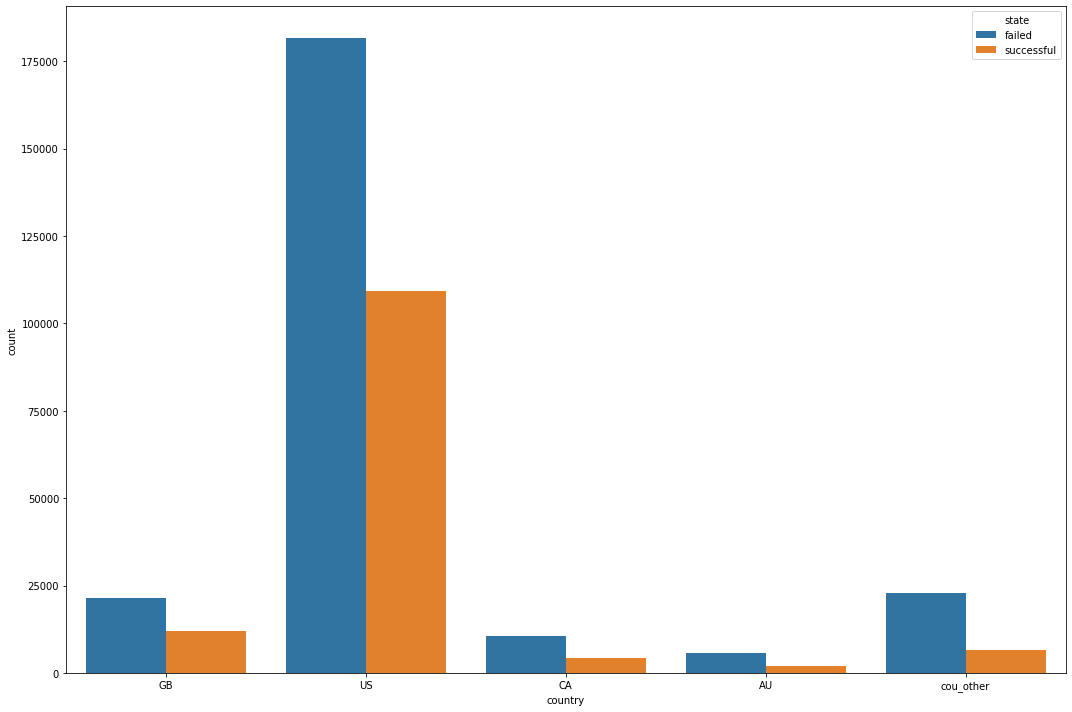

In [50]:
# countryとstateの関係性
data_c = pd.crosstab(columns=data['state'], index=data['country'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15,10))
sns.countplot(x='country', hue='state', data=data)
plt.tight_layout()

### launched & deadline

launchedとdeadlineのデータからは
- クラウドファンディングを募集していた時期
- クラウドファンディングの募集期間

の情報が得られる．<br>
クラウドファンディングを行う季節の情報はlaunchedとdeadlineの月のデータから得られる．<br>
募集期間に関してはdeadlineとlaunchedの差の日数をとることで得られる．

In [51]:
# deadlineをstr型からdatetime型に変更
data['deadline'] = pd.to_datetime(data['deadline'])
# deadlineの一つ目のデータの月を抽出
print(data['deadline'][0].month)

10


In [52]:
# launchedについてもdatetime型に変更
data['launched'] = pd.to_datetime(data['launched'])

In [53]:
# 募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days
data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58 days 11:47:32,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59 days 19:16:03,59
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44 days 23:39:10,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29 days 20:35:49,29
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55 days 15:24:57,55


### time_period_days

time_period_daysは何日間クラウドファンディングの募集を行っていたかを表す新しい変数である．<br>
この変数の各々の数値について出現頻度のグラフを以下に示す．

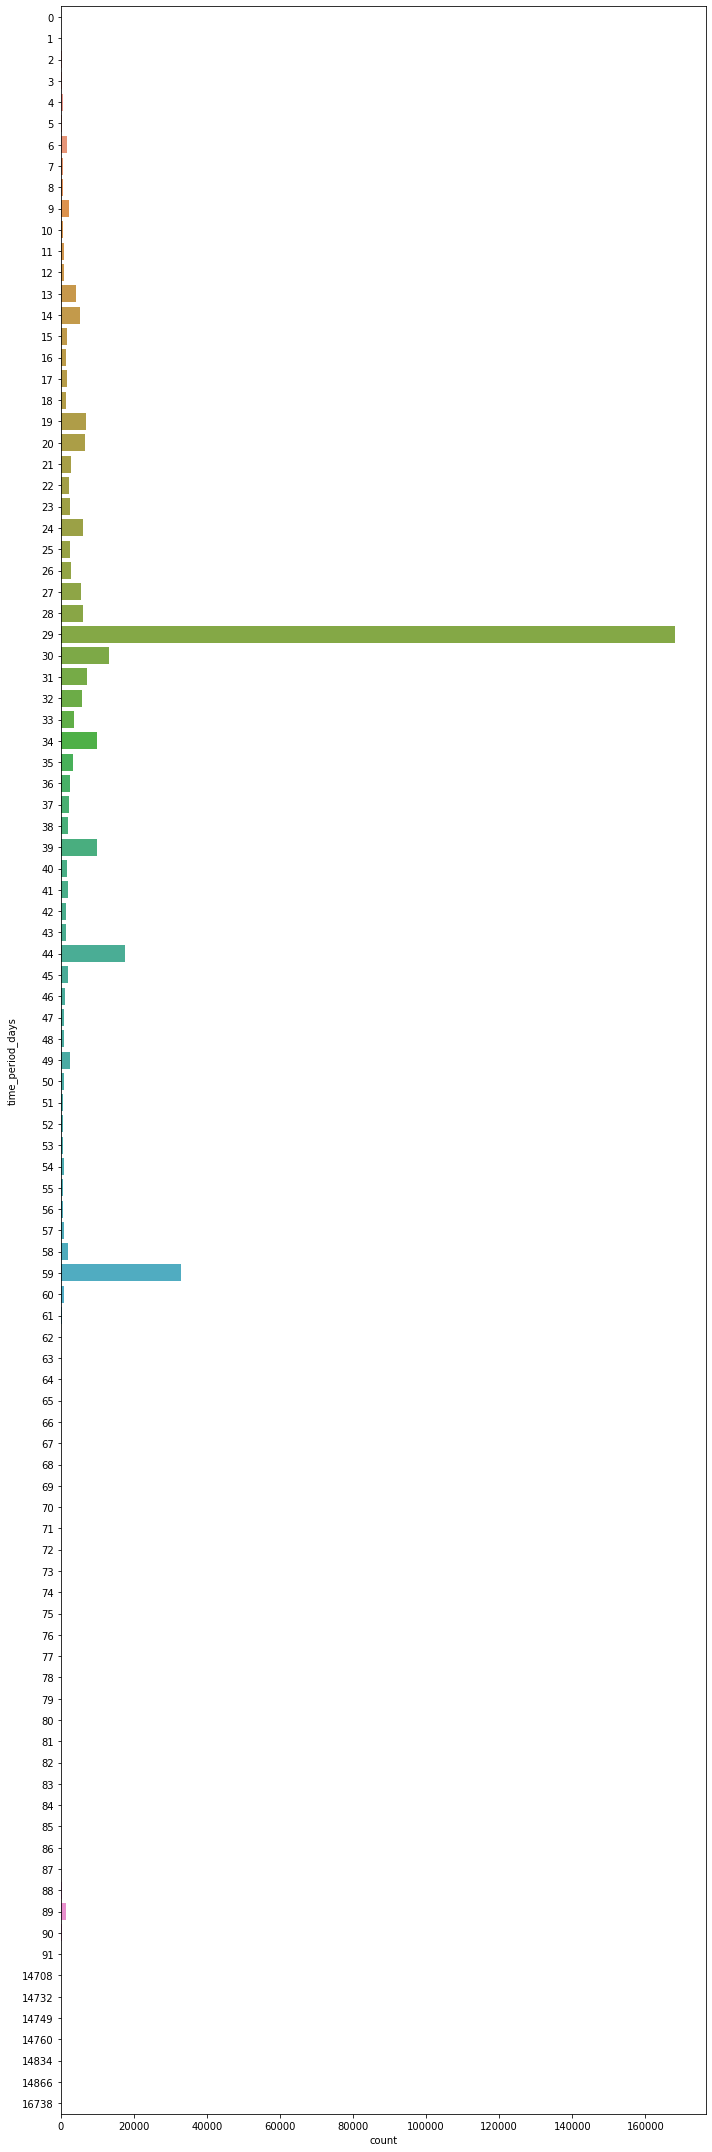

In [54]:
plt.figure(figsize=(10, 30))
sns.countplot(y='time_period_days', data=data)
plt.tight_layout()

In [55]:
data['time_period_days'].value_counts()

29       168112
59        33018
44        17552
30        13197
34        10014
          ...  
14732         1
14760         1
16738         1
14866         1
14834         1
Name: time_period_days, Length: 99, dtype: int64

In [56]:
data_29days = data['time_period_days']==29
print(f'29日間募集を行っていた件数 : {data_29days.sum() / data.shape[0]}')

29日間募集を行っていた件数 : 0.44727054078358547


In [57]:
data_time_period_days = data['time_period_days'].value_counts()
data_time_period_days = pd.DataFrame(data_time_period_days)

print('time_period_daysの出現回数が50回以下のカテゴリ数')
print(sum(data_time_period_days['time_period_days'] <= 50))
print('time_period_daysの出現回数が50回以下のデータ数')
print(data_time_period_days[data_time_period_days['time_period_days'] <= 50].sum()[0] / data.shape[0])

time_period_daysの出現回数が50回以下のカテゴリ数
10
time_period_daysの出現回数が50回以下のデータ数
0.00030330280794546935


In [58]:
data['time_period_days'].max()

16738

In [59]:
data[data['time_period_days']==16738]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
316658,Student Auditions Music 2015,Publishing,Publishing,cur_other,2015-10-31,1900.0,1970-01-01 01:00:00,failed,cou_other,1905.97,16738 days 23:00:00,16738


この分布から29日間募集しているものが多く全体の44.72%を占めていることがわかる．<br>
また最大で16738日間(約45年間)行っているものもあることがわかった．<br>
しかしこのデータはlaunchedが1970年1月1日になっており，以下のkickstarterのHPに記載されているkickstarterの誕生(2009年4月28日)以前から存在することになるので，外れ値であると考えられる．<br>
https://www.kickstarter.com/about?ref=global-footer<br>
ここでlaunchedのデータについて2009年4月28日以前に開始されているデータは以下の12件である．

In [60]:
data[data['launched'] <= datetime.datetime(2009, 4, 28)]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
2822,Salt of the Earth: A Dead Sea Movie (Canceled),Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,failed,US,5000.00,14866 days 23:00:00,14866
47802,1st Super-Size Painting - Social Network Owned...,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,failed,US,15000.00,14834 days 23:00:00,14834
74841,"""ICHOR"" (Canceled)",Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,failed,US,700.00,14749 days 23:00:00,14749
93894,"Support Solo Theater! Help ""Ungrateful Daughte...",Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,failed,US,4000.00,14760 days 23:00:00,14760
121749,Pantshirts,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,1900.00,28 days 09:49:21,28
137539,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,20.00,8 days 02:07:57,8
168009,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,1000.00,39 days 02:57:12,39
246089,"Help RIZ Make A Charity Album: 8 Songs, 8 Caus...",Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,failed,US,10000.00,14732 days 23:00:00,14732
271793,Identity Communications Infographic (Canceled),Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,failed,US,500.00,14708 days 23:00:00,14708
316658,Student Auditions Music 2015,Publishing,Publishing,cur_other,2015-10-31,1900.0,1970-01-01 01:00:00,failed,cou_other,1905.97,16738 days 23:00:00,16738


この12件のうちlaunchedが1970-01-01でない5件については，2009年4月28日以前から開始されているが募集期間の長さから考えて異常と言える数値ではないのでこの値を使用する．<br>
一方，launchedが1970-01-01となった7件については明らかに異常であるので，time_period_daysが29日になるようにlaunchedを変更する．<br>
29日としたのは募集期間が29日間のデータが最も多かったからである．

In [61]:
data['launched'][2822] =  datetime.datetime(2010, 8, 17)
data.loc[2822]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                Salt of the Earth: A Dead Sea Movie (Canceled)
category                                              Film & Video
main_category                                         Film & Video
currency                                                       USD
deadline                                       2010-09-15 00:00:00
goal                                                         5e+03
launched                                       2010-08-17 00:00:00
state                                                       failed
country                                                         US
usd_goal_real                                                5e+03
time_period                                    14866 days 23:00:00
time_period_days                                             14866
Name: 2822, dtype: object

In [62]:
data['launched'][47802] =  datetime.datetime(2010, 7, 16)
data.loc[47802]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                1st Super-Size Painting - Social Network Owned...
category                                                          Art
main_category                                                     Art
currency                                                          USD
deadline                                          2010-08-14 00:00:00
goal                                                          1.5e+04
launched                                          2010-07-16 00:00:00
state                                                          failed
country                                                            US
usd_goal_real                                                 1.5e+04
time_period                                       14834 days 23:00:00
time_period_days                                                14834
Name: 47802, dtype: object

In [63]:
data['launched'][74841] =  datetime.datetime(2010, 4, 22)
data.loc[74841]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                "ICHOR"  (Canceled)
category                   Film & Video
main_category              Film & Video
currency                            USD
deadline            2010-05-21 00:00:00
goal                              7e+02
launched            2010-04-22 00:00:00
state                            failed
country                              US
usd_goal_real                     7e+02
time_period         14749 days 23:00:00
time_period_days                  14749
Name: 74841, dtype: object

In [64]:
data['launched'][93894] =  datetime.datetime(2010, 5, 3)
data.loc[93894]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                Support Solo Theater! Help "Ungrateful Daughte...
category                                                      Theater
main_category                                                 Theater
currency                                                          USD
deadline                                          2010-06-01 00:00:00
goal                                                            4e+03
launched                                          2010-05-03 00:00:00
state                                                          failed
country                                                            US
usd_goal_real                                                   4e+03
time_period                                       14760 days 23:00:00
time_period_days                                                14760
Name: 93894, dtype: object

In [65]:
data['launched'][246089] =  datetime.datetime(2010, 4, 5)
data.loc[246089]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                Help RIZ Make A Charity Album: 8 Songs, 8 Caus...
category                                                        Music
main_category                                                   Music
currency                                                          USD
deadline                                          2010-05-04 00:00:00
goal                                                            1e+04
launched                                          2010-04-05 00:00:00
state                                                          failed
country                                                            US
usd_goal_real                                                   1e+04
time_period                                       14732 days 23:00:00
time_period_days                                                14732
Name: 246089, dtype: object

In [66]:
data['launched'][271793] =  datetime.datetime(2010, 3, 12)
data.loc[271793]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                Identity Communications Infographic (Canceled)
category                                                    Design
main_category                                               Design
currency                                                       USD
deadline                                       2010-04-10 00:00:00
goal                                                         5e+02
launched                                       2010-03-12 00:00:00
state                                                       failed
country                                                         US
usd_goal_real                                                5e+02
time_period                                    14708 days 23:00:00
time_period_days                                             14708
Name: 271793, dtype: object

In [67]:
data['launched'][316658] =  datetime.datetime(2015, 10, 2)
data.loc[316658]

/Users/suke/python_env/py3env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


name                Student Auditions Music 2015
category                              Publishing
main_category                         Publishing
currency                               cur_other
deadline                     2015-10-31 00:00:00
goal                                     1.9e+03
launched                     2015-10-02 00:00:00
state                                     failed
country                                cou_other
usd_goal_real                            1.9e+03
time_period                  16738 days 23:00:00
time_period_days                           16738
Name: 316658, dtype: object

In [68]:
# 再度確認
data[data['launched'] <= datetime.datetime(2009, 4, 28)]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
121749,Pantshirts,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,1900.0,28 days 09:49:21,28
137539,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,20.0,8 days 02:07:57,8
168009,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,1000.0,39 days 02:57:12,39
319623,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,failed,US,80000.0,87 days 23:52:07,87
322995,Offline Wikipedia iPhone app,Software,Technology,USD,2009-07-14,99.0,2009-04-25 17:36:21,successful,US,99.0,79 days 06:23:39,79


In [69]:
# 再度，募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days

In [70]:
data['time_period_days'].value_counts()

29    168119
59     33018
44     17552
30     13197
34     10014
       ...  
82        54
76        52
73        46
78        39
91        22
Name: time_period_days, Length: 92, dtype: int64

launchedの異常値はこれで取り除くことができたが，deadlineについても異常値の除去を行う必要がある．<br>
deadlineの異常値として考えられるものはlaunchedがdeadlineよりも後に来ている，つまり変数time_periodが負の値になっている状況である．<br>
まず異常値の候補である，変数time_period_daysが0以下のデータを抽出する．

In [71]:
data[data['time_period_days']<=0]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
888,Zombme,Video Games,Games,GBP,2015-06-11,5.00e+03,2015-06-10 19:03:39,failed,GB,7.74e+03,0 days 04:56:21,0
926,Musical Help for Trouble with Numbers (one of ...,Classical Music,Music,USD,2016-02-19,5.00e+02,2016-02-18 04:29:22,failed,US,5.00e+02,0 days 19:30:38,0
10361,Cloud Based Project Analytics Dashboards,Software,Technology,USD,2017-03-05,1.00e+07,2017-03-04 01:25:03,failed,US,1.00e+07,0 days 22:34:57,0
12390,Interior Garden (1978),Film & Video,Film & Video,GBP,2016-06-15,1.30e+02,2016-06-14 02:24:00,successful,GB,1.86e+02,0 days 21:36:00,0
20200,The Next Winged Queen (number 4!),Art,Art,USD,2016-04-02,8.89e+03,2016-04-01 08:38:27,failed,US,8.89e+03,0 days 15:21:33,0
...,...,...,...,...,...,...,...,...,...,...,...,...
365859,A £5 Poem,Poetry,Publishing,GBP,2014-03-02,5.00e+00,2014-03-01 13:20:34,successful,GB,8.39e+00,0 days 10:39:26,0
368167,Living Your Best Life,Digital Art,Art,cur_other,2016-08-02,5.00e+00,2016-08-01 21:44:53,successful,cou_other,3.73e+00,0 days 02:15:07,0
369608,Cookie Fury : The 3.5$ Game,Tabletop Games,Games,EUR,2017-08-06,6.90e+01,2017-08-05 18:05:40,failed,cou_other,8.12e+01,0 days 05:54:20,0
372775,What I Heard,Publishing,Publishing,USD,2016-02-28,2.50e+02,2016-02-27 04:40:59,successful,US,2.50e+02,0 days 19:19:01,0


募集期間が1日以下のデータは102件あることがわかる．<br>
この中でtime_periodが負の値になっているものを見つけることを考える．<br>
ここでtime_periodはdeadline - launchedを計算しており，time_periodの絶対値とtime_periodが一致しないデータは異常であると考えられるので，全データに対してtime_periodとtime_periodの絶対値の比較を行う．<br>

In [72]:
data[data['time_period']!=abs(data['deadline'] - data['launched'])]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days


上記のようにtime_periodとtime_periodの絶対値が一致しないデータは存在しないため，deadlineについては異常値は存在しないと考えられる．

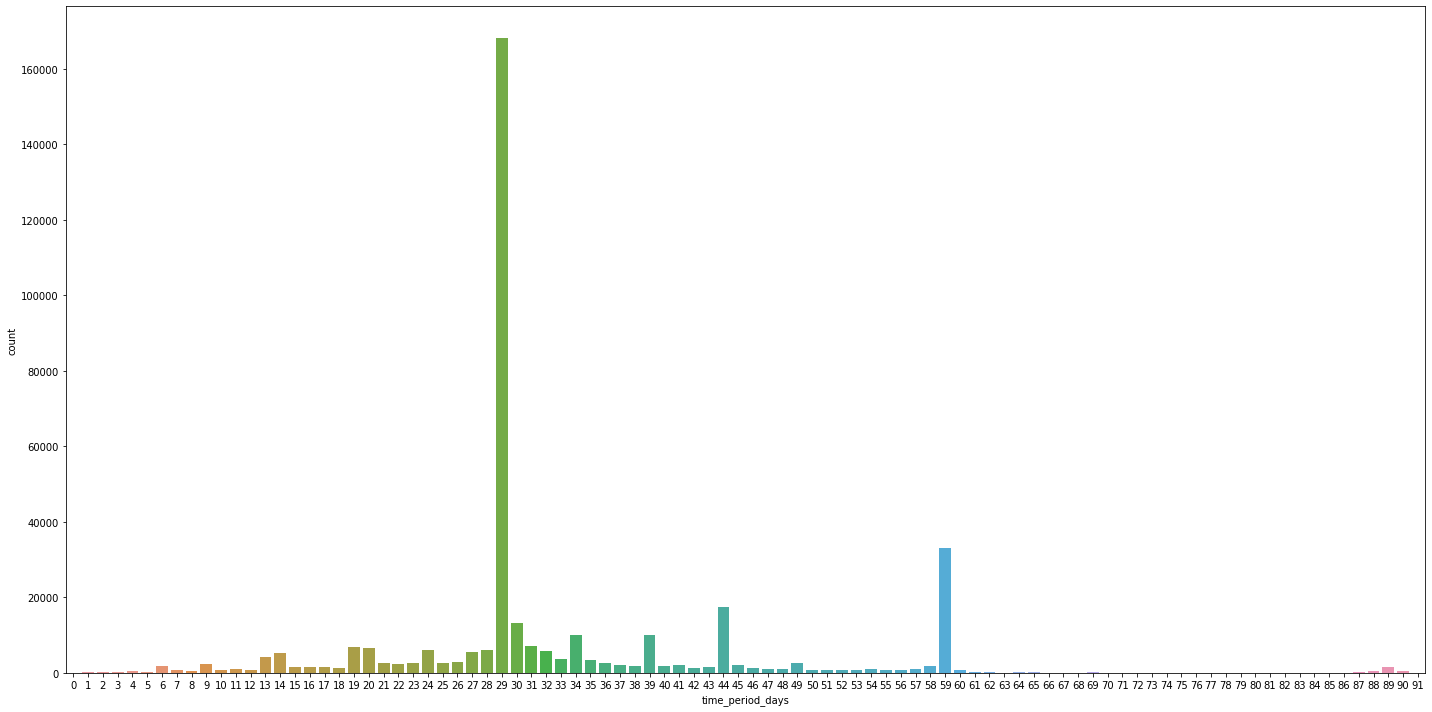

In [73]:
# 異常値変更後の頻度分布
plt.figure(figsize=(20, 10))
sns.countplot(x='time_period_days', data=data)
plt.tight_layout()

In [74]:
# 異常値変更後の最大値
data['time_period_days'].max()

91

変数time_periodは日数をtime_period_daysとして取り出したので削除する．

In [75]:
# dataから説明変数として用いない変数を消去
data.drop(['time_period'], axis=1, inplace=True)

data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55


### launched_month & launched_year

ここではlaunchedの月と年の情報を抽出する．<br>
月の情報はlaunchedになった時期の情報を持っており，季節による違いが見えると考えた．<br>
年の情報はlaunchedされた年によってkickstarterの流行り廃りという情報が見えると考えた．

In [76]:
data['launched_month'] = data['launched'].dt.month
data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58,8
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59,9
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44,1
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29,3
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55,7


In [77]:
data['launched_year'] = data['launched'].dt.year
data.head()

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58,8,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59,9,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44,1,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29,3,2012
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55,7,2015


launchedとdeadlineについては
- 特殊なデータ型(datetime型)で相互の比較が難しい
- 詳細な日付を用いるメリットは少ない

などの理由から今後使用しないため，削除する．

In [78]:
# dataから説明変数として用いない変数を消去
data.drop(['deadline', 'launched'], axis=1, inplace=True)

data.head()

,name,category,main_category,currency,goal,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,1000.0,failed,GB,1533.95,58,8,2015
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,30000.0,failed,US,30000.00,59,9,2017
2,Where is Hank?,Narrative Film,Film & Video,USD,45000.0,failed,US,45000.00,44,1,2013
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,5000.0,failed,US,5000.00,29,3,2012
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,19500.0,failed,US,19500.00,55,7,2015


### goal & usd_goal_real

goalとusd_goal_realはどちらも集めたい金額を表している．<br>
goalはUSDやGBPなどの異なる通貨が同一の値として表示されており，異なる通貨は直接比較することができないので，分類にそのまま用いることは難しい．<br>
一方usd_goal_realは全てUSDに変換された値なので，値同士を直接比較することができる．<br>
よってここからはgoalではなくusd_goal_realについて見ていく．

In [79]:
print(len(set(data['usd_goal_real'])))

49884


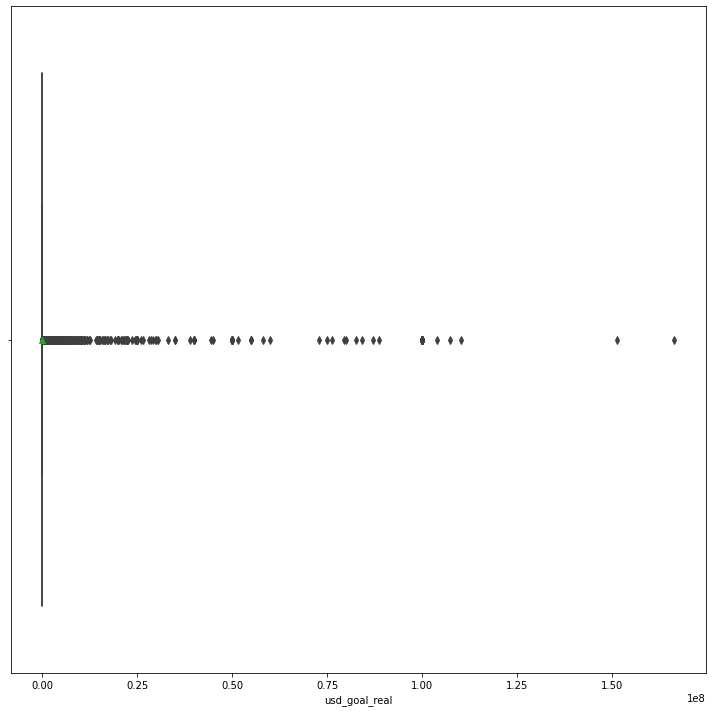

In [80]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='usd_goal_real', data=data, showmeans=True)
plt.tight_layout()
plt.show()

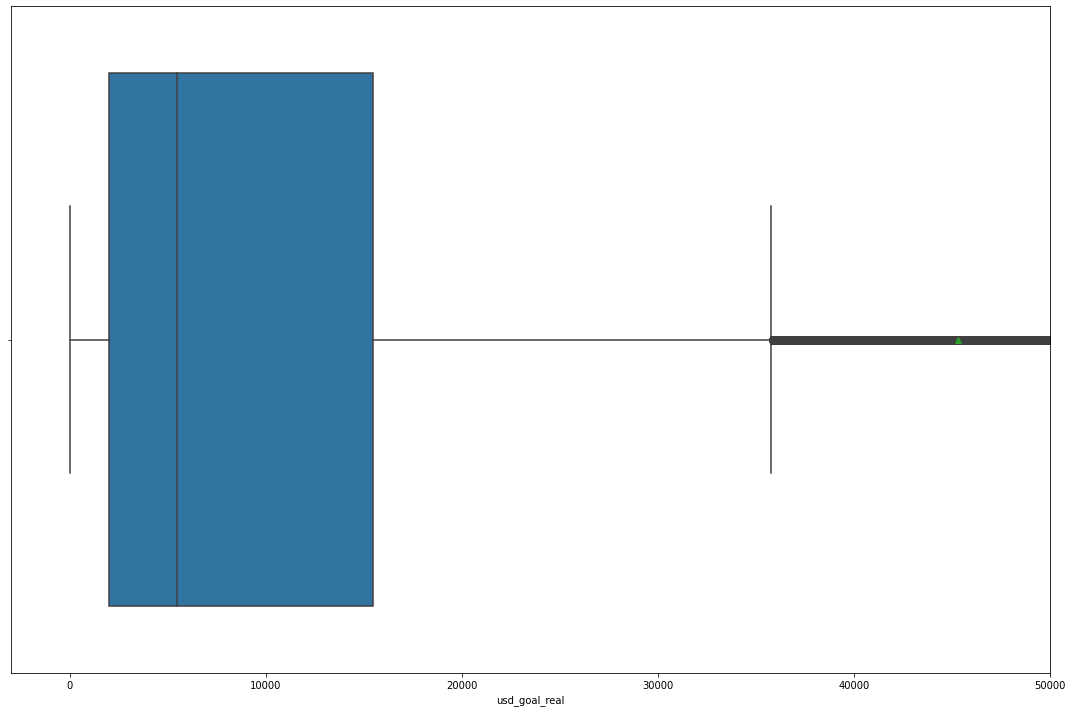

In [81]:
# 上図の0~5*10^4の範囲を拡大したもの
plt.figure(figsize=(15, 10))
sns.boxplot(x='usd_goal_real', data=data, showmeans=True, hue='state')
plt.xlim(-3*10**3, 5*10**4)
plt.tight_layout()

In [82]:
data_usd_goal_real = data['usd_goal_real']

print(f'最小値 : {data_usd_goal_real.min()}')
print(f'最大値 : {data_usd_goal_real.max()}')
print(f'平均 : {data_usd_goal_real.mean()}')
print(f'第三四分位数 : {data_usd_goal_real.quantile(0.75)}')

最小値 : 0.01
最大値 : 166361390.71
平均 : 45327.20217002516
第三四分位数 : 15500.0


usd_goal_realは約5万種で構成されており，
- 最小値 : $0.01$USD
- 最大値 : $1.66\times 10^8$USD
- 平均値 : $4.53\times 10^4$USD

である．<br>
また箱ヒゲ図の分布からusd_goal_realが低い募集が非常に多く，75%の募集が15500USD以下の募集であることがわかる．<br>
以上より
- usd_goal_realには負の値は含まれていない
- usd_goal_realは非常に広範囲に分布しているが，異常と呼べる値は含まれていない

ことがわかる．<br>
よってこのusd_goal_realについてはこのまま使用する．

goalについては
- 単位が揃っておらず比較ができない
- 金額の情報はusd_goal_realに含まれている

などの理由から今後使用しないため，今後の計算量の削減のため削除する．<br>
また説明変数の比較のためにnameをあえて残していたが，ここで削除する．

In [83]:
# dataから説明変数として用いない変数を消去
data.drop(['goal', 'name'], axis=1, inplace=True)

data.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,Poetry,Publishing,GBP,failed,GB,1533.95,58,8,2015
1,Narrative Film,Film & Video,USD,failed,US,30000.00,59,9,2017
2,Narrative Film,Film & Video,USD,failed,US,45000.00,44,1,2013
3,Music,Music,USD,failed,US,5000.00,29,3,2012
4,Film & Video,Film & Video,USD,failed,US,19500.00,55,7,2015


## まとめ

ここで行った操作をまとめて書き記す．<br>
- 目的変数 : stateがliveのデータを除外，successful以外のstateをfailedに統一
- 説明変数
 - currency : USD, GBP, EUR, CAD, AUD以外をcur_otherに統一
 - country : US, GB, CA, AU以外をcou_otherに統一
 - time_period_days : launchedとdeadlineの差の日数を取得
 - launched : 異常値をtime_period_daysが29日になるように変更
 - launched_month : launchedの月の情報を抽出
 - launched_year : launchedの年の情報を抽出

category, main_category, usd_goal_realについては特別な操作を行わなかった．<br>
launched, deadline, goalについては扱いが難しいなどの理由から削除した．

In [84]:
# いくつかの操作を行った後のデータ
data.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,Poetry,Publishing,GBP,failed,GB,1533.95,58,8,2015
1,Narrative Film,Film & Video,USD,failed,US,30000.00,59,9,2017
2,Narrative Film,Film & Video,USD,failed,US,45000.00,44,1,2013
3,Music,Music,USD,failed,US,5000.00,29,3,2012
4,Film & Video,Film & Video,USD,failed,US,19500.00,55,7,2015


# 目的変数と説明変数の関係性

ここでは目的変数と説明変数の関係性を可視化によって確認する．

## 変数の数値変換

変数stateと相関がある変数を見つけることが目的なので，カテゴリ変数を数値に変換する必要がある．<br>
まず全てのカテゴリ変数をlabel encodingを行って数値に変換する．

In [85]:
# dataを直接変更するのではなくcopyしたものを数値に変換する
data_exp = data.copy(deep=True)

### 目的変数の変換

In [86]:
# failedを0，successfulを1に変換
data_exp = data_exp.replace({'failed' : 0, 'successful' : 1})
data_exp.head(10)

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,Poetry,Publishing,GBP,0,GB,1533.95,58,8,2015
1,Narrative Film,Film & Video,USD,0,US,30000.00,59,9,2017
2,Narrative Film,Film & Video,USD,0,US,45000.00,44,1,2013
3,Music,Music,USD,0,US,5000.00,29,3,2012
4,Film & Video,Film & Video,USD,0,US,19500.00,55,7,2015
5,Restaurants,Food,USD,1,US,50000.00,34,2,2016
6,Food,Food,USD,1,US,1000.00,19,12,2014
7,Drinks,Food,USD,0,US,25000.00,44,2,2016
8,Product Design,Design,USD,0,US,125000.00,34,4,2014
9,Documentary,Film & Video,USD,0,US,65000.00,29,7,2014


### 説明変数の変換

In [87]:
# categoryの変換
le = LabelEncoder()
encoded = le.fit(data_exp['category'])
data_exp['category'] = encoded.transform(data_exp['category'])
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,Publishing,GBP,0,GB,1533.95,58,8,2015
1,93,Film & Video,USD,0,US,30000.00,59,9,2017
2,93,Film & Video,USD,0,US,45000.00,44,1,2013
3,90,Music,USD,0,US,5000.00,29,3,2012
4,55,Film & Video,USD,0,US,19500.00,55,7,2015


In [88]:
# currencyの変換
encoded = le.fit(data_exp['currency'])
data_exp['currency'] = encoded.transform(data_exp['currency'])
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,Publishing,3,0,GB,1533.95,58,8,2015
1,93,Film & Video,4,0,US,30000.00,59,9,2017
2,93,Film & Video,4,0,US,45000.00,44,1,2013
3,90,Music,4,0,US,5000.00,29,3,2012
4,55,Film & Video,4,0,US,19500.00,55,7,2015


In [89]:
# countryの変換
encoded = le.fit(data_exp['country'])
data_exp['country'] = encoded.transform(data_exp['country'])
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,Publishing,3,0,2,1533.95,58,8,2015
1,93,Film & Video,4,0,3,30000.00,59,9,2017
2,93,Film & Video,4,0,3,45000.00,44,1,2013
3,90,Music,4,0,3,5000.00,29,3,2012
4,55,Film & Video,4,0,3,19500.00,55,7,2015


In [90]:
# main_categoryの変換
encoded = le.fit(data_exp['main_category'])
data_exp['main_category'] = encoded.transform(data_exp['main_category'])
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,12,3,0,2,1533.95,58,8,2015
1,93,6,4,0,3,30000.00,59,9,2017
2,93,6,4,0,3,45000.00,44,1,2013
3,90,10,4,0,3,5000.00,29,3,2012
4,55,6,4,0,3,19500.00,55,7,2015


## 変数のスケール変換

数値変数のスケールが大きく違う場合，
- 数値の大きい変数が重視されやすくなる
- 線形モデルなどの説明性が下がる

などの問題が生じることがある．<br>
今回の変数ではlaunched_monchは$1 \sim 12$の範囲に収まっているが，usd_goal_realは$0.01 \sim 1.66 \times 10^8$の範囲であるため，スケールに大きな違いがあることがわかる．<br>
よってtime_period_days, launched_month, launched_yearに対しては標準化の操作を行い，usd_goal_realについては対数値をとるような操作を行う．

In [91]:
# time_period_daysの標準化
data_exp['time_period_days_std'] = (data_exp['time_period_days'] - data_exp['time_period_days'].mean()) / data_exp['time_period_days'].std(ddof=0)
data_exp['time_period_days'] = data_exp['time_period_days_std']
data_exp.drop(['time_period_days_std'], axis=1, inplace=True)
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,12,3,0,2,1533.95,1.94,8,2015
1,93,6,4,0,3,30000.00,2.02,9,2017
2,93,6,4,0,3,45000.00,0.85,1,2013
3,90,10,4,0,3,5000.00,-0.33,3,2012
4,55,6,4,0,3,19500.00,1.71,7,2015


In [92]:
# launched_monthの標準化
data_exp['launched_month_std'] = (data_exp['launched_month'] - data_exp['launched_month'].mean()) / data_exp['launched_month'].std(ddof=0)
data_exp['launched_month'] = data_exp['launched_month_std']
data_exp.drop(['launched_month_std'], axis=1, inplace=True)
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,12,3,0,2,1533.95,1.94,0.48,2015
1,93,6,4,0,3,30000.00,2.02,0.78,2017
2,93,6,4,0,3,45000.00,0.85,-1.64,2013
3,90,10,4,0,3,5000.00,-0.33,-1.03,2012
4,55,6,4,0,3,19500.00,1.71,0.17,2015


In [93]:
# launched_yearの標準化
data_exp['launched_year_std'] = (data_exp['launched_year'] - data_exp['launched_year'].mean()) / data_exp['launched_year'].std(ddof=0)
data_exp['launched_year'] = data_exp['launched_year_std']
data_exp.drop(['launched_year_std'], axis=1, inplace=True)
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,108,12,3,0,2,1533.95,1.94,0.48,0.40
1,93,6,4,0,3,30000.00,2.02,0.78,1.45
2,93,6,4,0,3,45000.00,0.85,-1.64,-0.64
3,90,10,4,0,3,5000.00,-0.33,-1.03,-1.16
4,55,6,4,0,3,19500.00,1.71,0.17,0.40


In [94]:
# usd_goal_realのlog変換
data_exp['usd_goal_real_log'] = data_exp['usd_goal_real'].apply(np.log)
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year,usd_goal_real_log
0,108,12,3,0,2,1533.95,1.94,0.48,0.40,7.34
1,93,6,4,0,3,30000.00,2.02,0.78,1.45,10.31
2,93,6,4,0,3,45000.00,0.85,-1.64,-0.64,10.71
3,90,10,4,0,3,5000.00,-0.33,-1.03,-1.16,8.52
4,55,6,4,0,3,19500.00,1.71,0.17,0.40,9.88


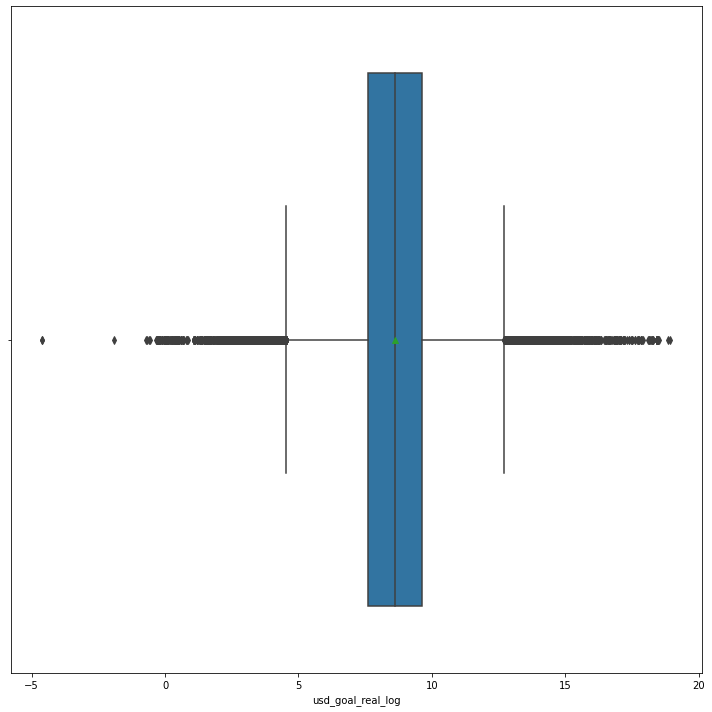

In [95]:
# log変換後の分布
plt.figure(figsize=(10, 10))
sns.boxplot(x='usd_goal_real_log', data=data_exp, showmeans=True)
plt.tight_layout()
plt.show()

<Figure size 720x720 with 0 Axes>

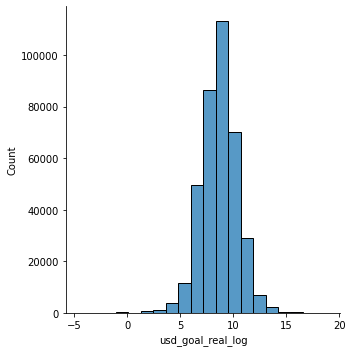

In [96]:
# log変換後の分布
plt.figure(figsize=(10, 10))
sns.displot(x='usd_goal_real_log', data=data_exp, bins=20)
plt.tight_layout()

## 目的変数と説明変数の相関

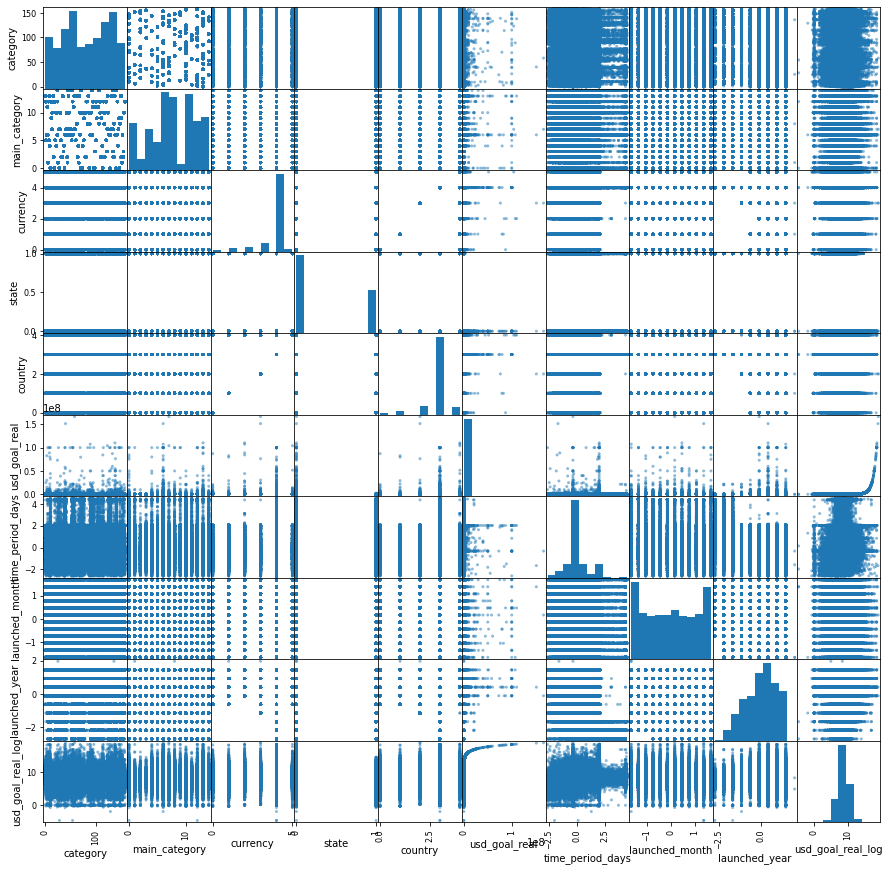

In [97]:
pd.plotting.scatter_matrix(data_exp, figsize=(15, 15))
plt.show()

<AxesSubplot:>

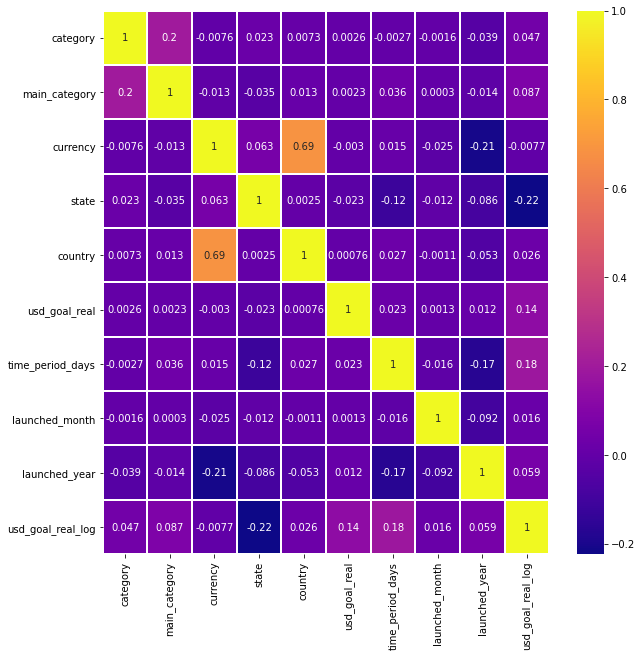

In [98]:
# 各変数の相関係数
plt.figure(figsize=(10, 10))
sns.heatmap(data_exp.corr(), annot=True, linewidths=1, cmap='plasma')

相関係数から見て，
- stateと相関の強い変数はusd_goal_real_log, time_period_daysであること
- currencyとcountry，categoryとmain_categoryは相関が強いため，双方を用いるとロジスティック回帰等では多重共線性の原因になりそうであること
- usd_goal_realとusd_goal_real_logはusd_goal_real_logの方が相関が強いため，usd_goal_real_logを使った方が良さそうであること

がわかる．

## 目的変数と説明変数の関係性

目的変数stateがsuccessfulなのかfailedなのかによって説明変数の分布に違いがあるのかを確認する．

main_category,Dance,Theater,Comics,Music,Art,Film & Video,Games,All,Design,Publishing,Photography,Food,Fashion,Crafts,Journalism,Technology
state,,,,,,,,,,,,,,,,
failed,0.38,0.4,0.46,0.53,0.59,0.63,0.64,0.64,0.65,0.69,0.69,0.75,0.75,0.76,0.79,0.8
successful,0.62,0.6,0.54,0.47,0.41,0.37,0.36,0.36,0.35,0.31,0.31,0.25,0.25,0.24,0.21,0.2


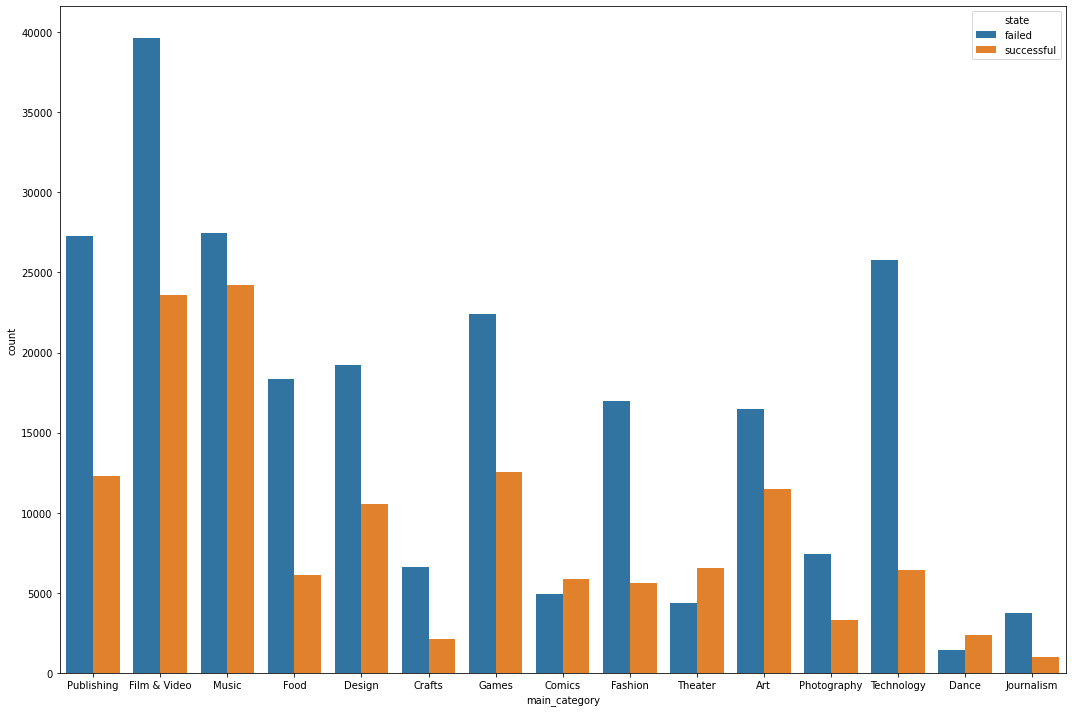

In [99]:
# 再度確認
data_c = pd.crosstab(columns=data['state'], index=data['main_category'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15, 10))
sns.countplot(x='main_category', hue='state', data=data)
plt.tight_layout()

category,Chiptune,Residencies,Anthologies,Dance,Letterpress,Indie Rock,Country & Folk,Classical Music,Theater,Performances,...,Hip-Hop,Television,Action,Candles,Food Trucks,Software,Video,Web,Mobile Games,Apps
state,,,,,,,,,,,,,,,,,,,,,
failed,0.23,0.28,0.33,0.33,0.35,0.36,0.37,0.37,0.38,0.38,...,0.84,0.84,0.85,0.87,0.87,0.88,0.88,0.91,0.91,0.94
successful,0.77,0.72,0.67,0.67,0.65,0.64,0.63,0.63,0.62,0.62,...,0.16,0.16,0.15,0.13,0.13,0.12,0.12,0.09,0.09,0.06


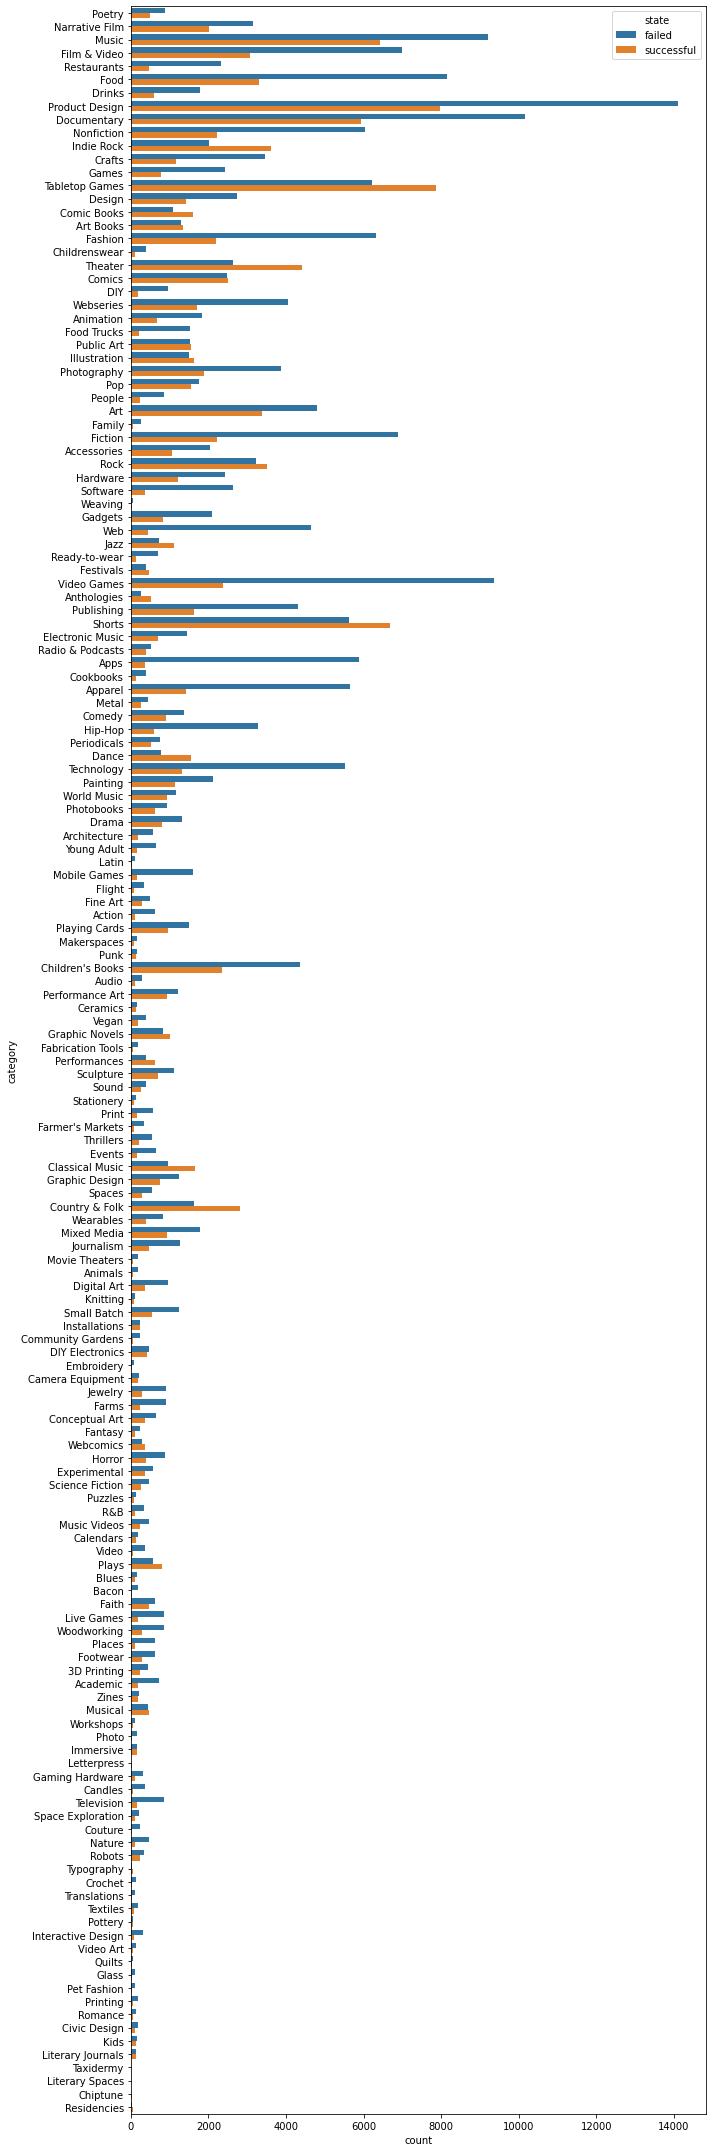

In [100]:
# 再度確認
data_c = pd.crosstab(columns=data['state'], index=data['category'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(10, 30))
sns.countplot(y='category', hue='state', data=data)
plt.tight_layout()

currency,USD,GBP,All,cur_other,CAD,AUD,EUR
state,,,,,,,
failed,0.63,0.64,0.64,0.71,0.72,0.74,0.77
successful,0.37,0.36,0.36,0.29,0.28,0.26,0.23


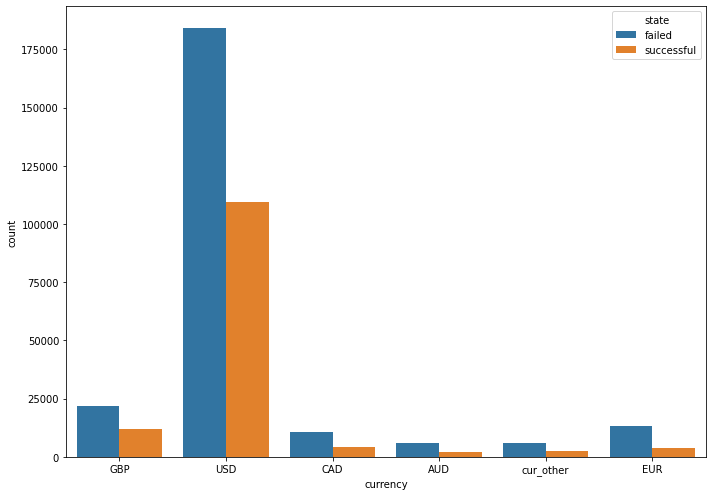

In [101]:
# 再度確認
data_c = pd.crosstab(columns=data['state'], index=data['currency'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(10, 7))
sns.countplot(x='currency', hue='state', data=data)
plt.tight_layout()

country,US,GB,All,CA,AU,cou_other
state,,,,,,
failed,0.62,0.64,0.64,0.72,0.74,0.78
successful,0.38,0.36,0.36,0.28,0.26,0.22


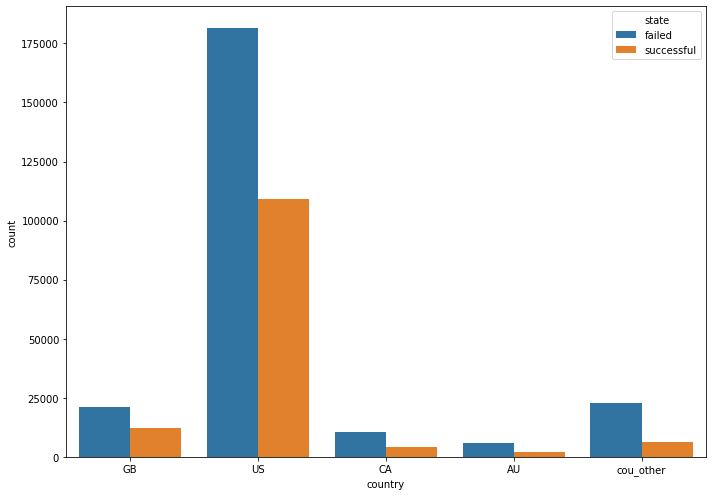

In [102]:
# 再度確認
data_c = pd.crosstab(columns=data['state'], index=data['country'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(10, 7))
sns.countplot(x='country', hue='state', data=data)
plt.tight_layout()

In [103]:
# スタージェスの公式から階級数を決定
def sturges_rule(n):
    return round(1 + math.log2(n))

sturges_rule(len(data['usd_goal_real']))

20

<Figure size 720x720 with 0 Axes>

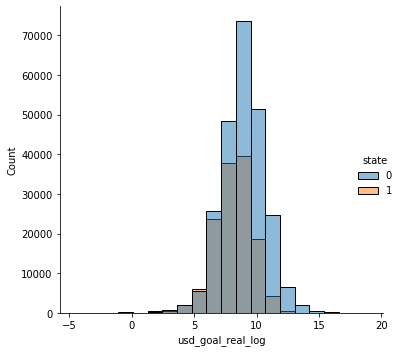

In [104]:
plt.figure(figsize=(10, 10))
sns.displot(x='usd_goal_real_log', data=data_exp, hue='state', bins=20)
plt.tight_layout()

In [105]:
data_c = pd.crosstab(columns=data['state'], index=data['time_period_days'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)

data_c.head(data_c.shape[0])

state,failed,successful
time_period_days,,
21,0.43,0.57
15,0.43,0.57
10,0.44,0.56
16,0.44,0.56
22,0.45,0.55
...,...,...
86,0.73,0.27
57,0.75,0.25
58,0.76,0.24


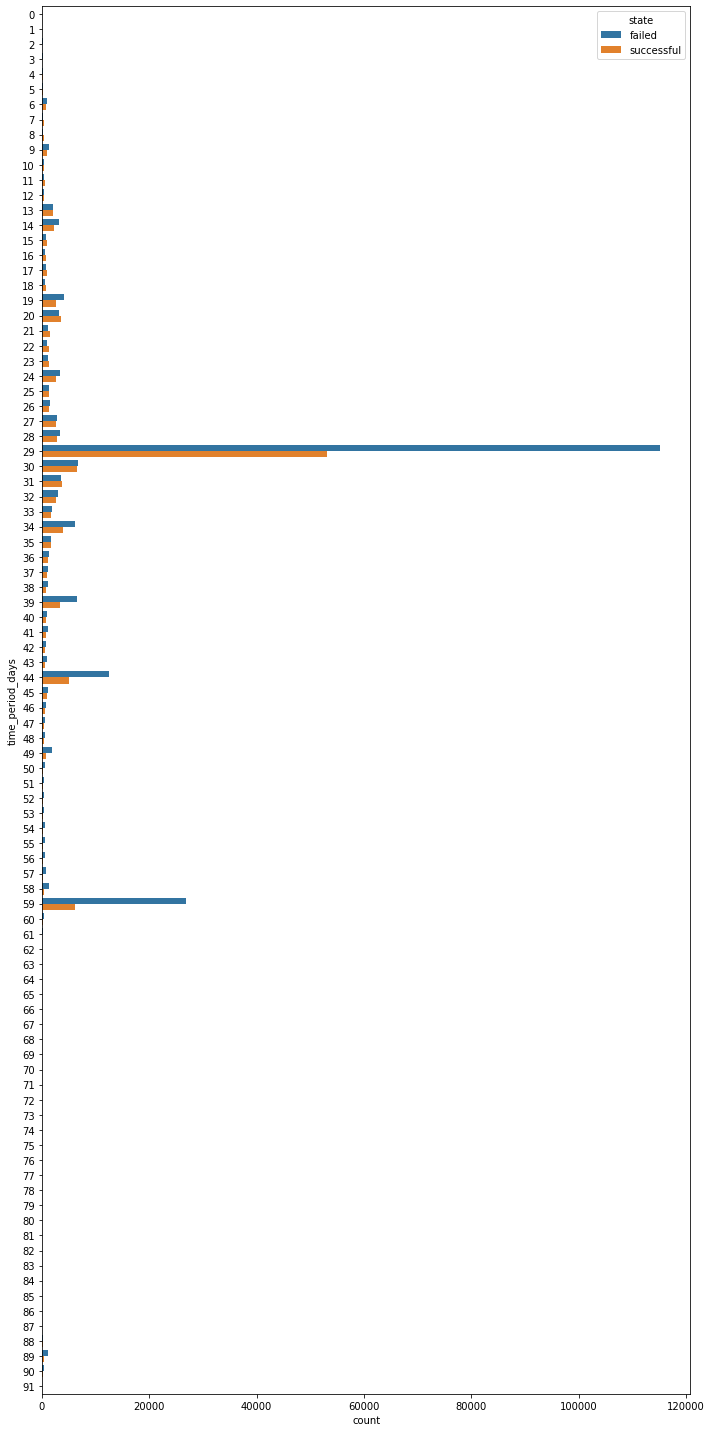

In [106]:
plt.figure(figsize=(10, 20))
sns.countplot(y='time_period_days', hue='state', data=data)
plt.tight_layout()

launched_month,3,4,2,10,5,11,9,6,All,1,8,12,7
state,,,,,,,,,,,,,
failed,0.62,0.63,0.63,0.63,0.63,0.64,0.64,0.64,0.64,0.66,0.66,0.68,0.68
successful,0.38,0.37,0.37,0.37,0.37,0.36,0.36,0.36,0.36,0.34,0.34,0.32,0.32


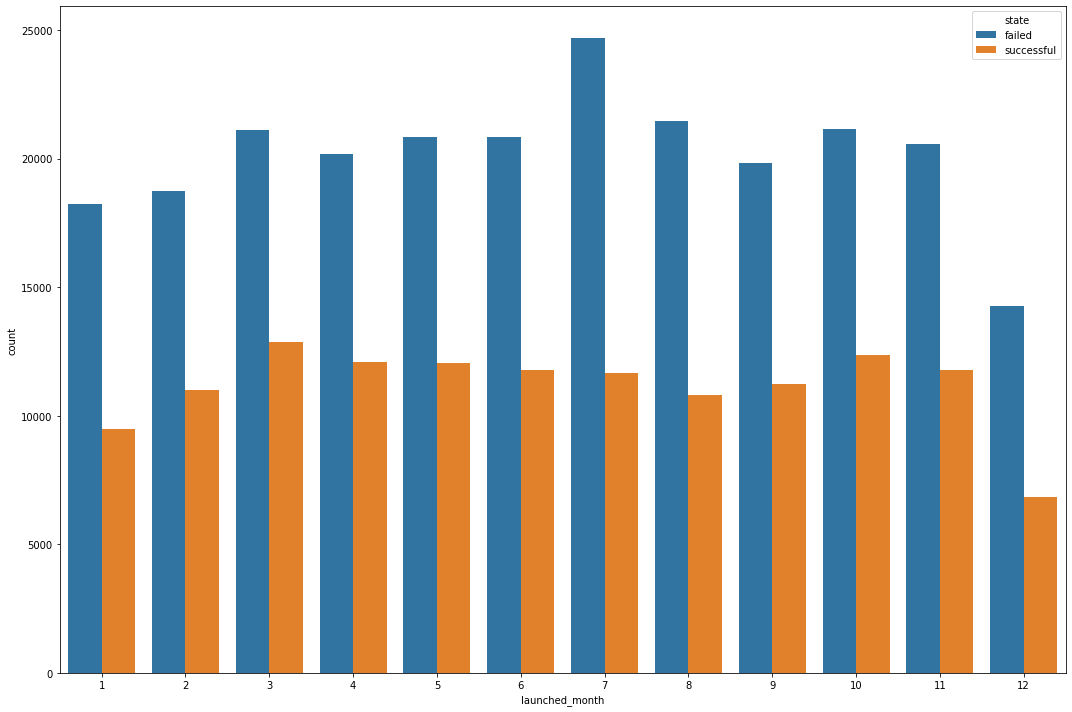

In [107]:
data_c = pd.crosstab(columns=data['state'], index=data['launched_month'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15, 10))
sns.countplot(x='launched_month', hue='state', data=data)
plt.tight_layout()

launched_year,2011,2010,2009,2012,2013,2017,All,2016,2014,2015,2018
state,,,,,,,,,,,
failed,0.54,0.56,0.56,0.57,0.57,0.63,0.64,0.67,0.69,0.73,1.0
successful,0.46,0.44,0.44,0.43,0.43,0.37,0.36,0.33,0.31,0.27,0.0


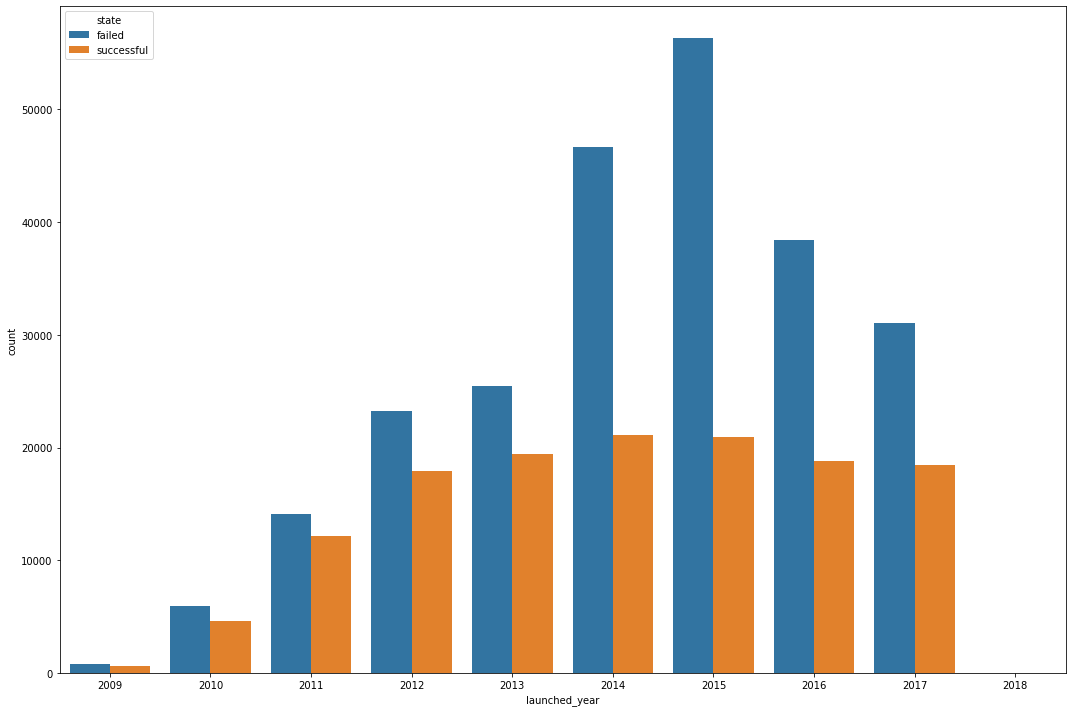

In [108]:
data_c = pd.crosstab(columns=data['state'], index=data['launched_year'], margins=True, normalize='index')
data_c = data_c.sort_values(by='successful', ascending=False)
display(data_c.T)

plt.figure(figsize=(15, 10))
sns.countplot(x='launched_year', hue='state', data=data)
plt.tight_layout()

## 目的変数と説明変数の関係性のまとめ

目的変数との相関係数が高い説明変数はtime_period_daysであった．<br>
全ての目的変数について説明変数との関係性を図示した結果，目的変数と関係のありそうであると感じた説明変数は以下の通りである．
- usd_goal_real_log
- time_period_days
- category
- main_category
- launched_year

関係性を図示した結果，time_period_daysが小さい，つまり募集期間が短いものの方が成功率が高いという少し意外な関係性が見えた．

## まとめ

ここで行った操作をまとめて書き記す．<br>
操作したデータはdata_exp．
- 目的変数 : failuedを0，successfulを1に変換
- 説明変数
 - category, main_category, country, currencyを数値に変換
 - time_period_days, launched_month, launched_yearを標準化
 - usd_goal_real_log : usd_goal_realを対数に変換

In [109]:
data_exp.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year,usd_goal_real_log
0,108,12,3,0,2,1533.95,1.94,0.48,0.40,7.34
1,93,6,4,0,3,30000.00,2.02,0.78,1.45,10.31
2,93,6,4,0,3,45000.00,0.85,-1.64,-0.64,10.71
3,90,10,4,0,3,5000.00,-0.33,-1.03,-1.16,8.52
4,55,6,4,0,3,19500.00,1.71,0.17,0.40,9.88


# データの前処理と特徴量選択

ここではデータの前処理として
- カテゴリ変数のone-hot encoding
- 数値変数のスケール変換
- one-hot encodingを行った場合の特徴量の選択

を行う．

## one-hot encoding

In [110]:
data_exp2 = data.copy(deep=True)

In [111]:
# failedを0，successfulを1に変換
data_exp2 = data_exp2.replace({'failed' : 0, 'successful' : 1})
data_exp2.head(10)

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year
0,Poetry,Publishing,GBP,0,GB,1533.95,58,8,2015
1,Narrative Film,Film & Video,USD,0,US,30000.00,59,9,2017
2,Narrative Film,Film & Video,USD,0,US,45000.00,44,1,2013
3,Music,Music,USD,0,US,5000.00,29,3,2012
4,Film & Video,Film & Video,USD,0,US,19500.00,55,7,2015
5,Restaurants,Food,USD,1,US,50000.00,34,2,2016
6,Food,Food,USD,1,US,1000.00,19,12,2014
7,Drinks,Food,USD,0,US,25000.00,44,2,2016
8,Product Design,Design,USD,0,US,125000.00,34,4,2014
9,Documentary,Film & Video,USD,0,US,65000.00,29,7,2014


In [112]:
# usd_goal_realのlog変換
data_exp2['usd_goal_real_log'] = data_exp2['usd_goal_real'].apply(np.log)
data_exp2.head()

,category,main_category,currency,state,country,usd_goal_real,time_period_days,launched_month,launched_year,usd_goal_real_log
0,Poetry,Publishing,GBP,0,GB,1533.95,58,8,2015,7.34
1,Narrative Film,Film & Video,USD,0,US,30000.00,59,9,2017,10.31
2,Narrative Film,Film & Video,USD,0,US,45000.00,44,1,2013,10.71
3,Music,Music,USD,0,US,5000.00,29,3,2012,8.52
4,Film & Video,Film & Video,USD,0,US,19500.00,55,7,2015,9.88


In [113]:
# get_dummiesで全カテゴリ変数をone-hot encoding
data_dummy = pd.get_dummies(data_exp2)
data_dummy.head()

,state,usd_goal_real,time_period_days,launched_month,launched_year,usd_goal_real_log,category_3D Printing,category_Academic,category_Accessories,category_Action,...,currency_CAD,currency_EUR,currency_GBP,currency_USD,currency_cur_other,country_AU,country_CA,country_GB,country_US,country_cou_other
0,0,1533.95,58,8,2015,7.34,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,30000.00,59,9,2017,10.31,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,45000.00,44,1,2013,10.71,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,5000.00,29,3,2012,8.52,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,19500.00,55,7,2015,9.88,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## one-hot encodingを行ったときの相関

one-hot encodingを行った変数を用いた場合の目的変数stateと各変数の相関係数を確認する．<br>
one-hot encodingを行うと変数が191になり相関係数を全て確認するのは難しいので，今回は目的変数との相関係数の絶対値が0.075以上の説明変数のみを示す．

In [114]:
# ダミー変数化したデータについて相関係数を算出
# 相関係数が0.075以上，-0.075以下のもののみ抽出
target_cc_value = 0.075

data_dummy_cc = data_dummy.corr()
data_dummy_cc_sorted = data_dummy_cc[['state']].sort_values(by=['state'], ascending=False)

print('正の相関')
display(data_dummy_cc_sorted[data_dummy_cc_sorted['state'] >= target_cc_value])
print('負の相関')
display(data_dummy_cc_sorted[data_dummy_cc_sorted['state'] <= (-1*target_cc_value)])

正の相関


,state
state,1.00
main_category_Music,0.09
main_category_Theater,0.09
category_Tabletop Games,0.08
category_Theater,0.08


負の相関


,state
category_Apps,-0.08
country_cou_other,-0.08
launched_year,-0.09
main_category_Technology,-0.10
time_period_days,-0.12
usd_goal_real_log,-0.22


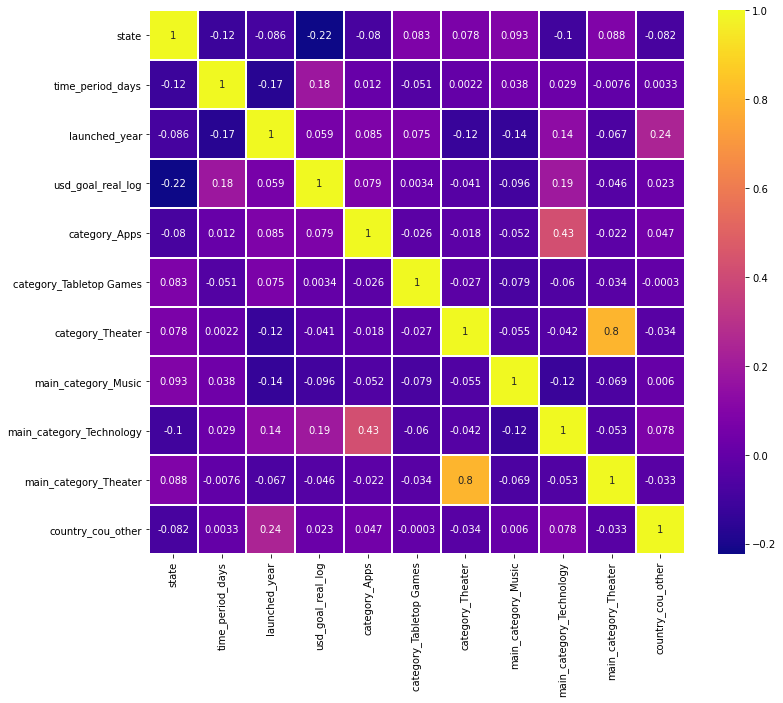

In [115]:
data_dummy_indexs = data_dummy_cc[(data_dummy_cc['state'] >= target_cc_value)|(data_dummy_cc['state'] <= (-1 * target_cc_value))].index
data_cc_target = data_dummy_cc.loc[data_dummy_indexs, data_dummy_indexs]
plt.figure(figsize=(12, 10))
sns.heatmap(data_cc_target, annot=True, linewidths=1, cmap='plasma')
plt.show()

相関係数からusd_goal_real_log, time_period_days, main_category_ categoryの相関係数が高いことがわかる．<br>
相関係数の絶対値が0.075以上の変数は以下のもの．
- usd_goal_real_log
- time_period_days
- main_category_Technology
- main_category_Music
- main_category_Theater
- launched_year	
- category_Tabletop Games
- country_cou_other
- category_Apps
- category_Theater

## one-hot encodingを行ったときの特徴量選択

相関係数から10つの説明変数が選択できそうであることがわかったが，相関係数の絶対値が0.075以上という基準で選択したものであり，その基準の根拠が無いことが問題である．<br>
そこでアルゴリズムによって特徴量を選択することを考える．
ここではステップワイズ法を用いて特徴量選択を行う．<br>
しかしステップワイズ法でいくつかの説明変数を選択する場合，200近い説明変数から$k$個の候補を得るには
${}_{200} C_{k}$の計算回数が必要になる．<br>
しかしこの計算を現実的な時間で解くためには$k = 5$以下という制約が付いてしまう．<br>
よって200の説明変数をある程度減らすことで少し大きな$k$をとることができるようにすることを考える．

そこで今回は，全説明変数から目的変数との相関係数の絶対値が0.06以上であるものをあらかじめ特徴量の候補として選択し，その中からいくつかの特徴量を得るということを行う．

In [116]:
# ダミー変数化したデータについて相関係数を算出
# 相関係数が0.06以上，-0.06以下のもののみ抽出
target_cc_value = 0.06

data_dummy_cc = data_dummy.corr()
data_dummy_cc_sorted = data_dummy_cc[['state']].sort_values(by=['state'], ascending=False)

print('正の相関')
display(data_dummy_cc_sorted[data_dummy_cc_sorted['state'] >= target_cc_value])
print('負の相関')
display(data_dummy_cc_sorted[data_dummy_cc_sorted['state'] <= (-1*target_cc_value)])

正の相関


,state
state,1.00
main_category_Music,0.09
main_category_Theater,0.09
category_Tabletop Games,0.08
category_Theater,0.08
country_US,0.07
category_Indie Rock,0.07
category_Shorts,0.07
main_category_Comics,0.07
currency_USD,0.06


負の相関


,state
category_Web,-0.07
category_Apps,-0.08
country_cou_other,-0.08
launched_year,-0.09
main_category_Technology,-0.10
time_period_days,-0.12
usd_goal_real_log,-0.22


In [117]:
print(data_dummy_cc_sorted[data_dummy_cc_sorted['state'] >= target_cc_value].count() + data_dummy_cc_sorted[data_dummy_cc_sorted['state'] <= (-1 * target_cc_value)].count())

state    18
dtype: int64


相関係数の絶対値が0.06以上の説明変数は18個ある．<br>
これらの説明変数からステップワイズ法を用いて特徴量を抽出する．

In [118]:
remove_columns = data_dummy_cc[(data_dummy_cc['state'] < target_cc_value)&(data_dummy_cc['state'] > (-1 * target_cc_value))].index
remove_columns = remove_columns.values

In [119]:
data_dummy_remove = data_dummy.drop(remove_columns, axis=1)
data_dummy_remove.head()

,state,time_period_days,launched_year,usd_goal_real_log,category_Apps,category_Country & Folk,category_Indie Rock,category_Shorts,category_Tabletop Games,category_Theater,category_Web,main_category_Comics,main_category_Music,main_category_Technology,main_category_Theater,currency_USD,country_US,country_cou_other
0,0,58,2015,7.34,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,59,2017,10.31,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0,44,2013,10.71,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,29,2012,8.52,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,0,55,2015,9.88,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [120]:
estimator = SGDClassifier(loss='log', max_iter=10000, fit_intercept=True, random_state=random_state, tol=1e-3)
rfecv = RFECV(estimator, cv=5, scoring='accuracy')

In [121]:
train_label = data_dummy_remove['state']
train_data = data_dummy_remove.drop('state', axis=1)

y = train_label.values
X = train_data.values

rfecv.fit(X, y)

RFECV(cv=5,
      estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                              early_stopping=False, epsilon=0.1, eta0=0.0,
                              fit_intercept=True, l1_ratio=0.15,
                              learning_rate='optimal', loss='log',
                              max_iter=10000, n_iter_no_change=5, n_jobs=None,
                              penalty='l2', power_t=0.5, random_state=1234,
                              shuffle=True, tol=0.001, validation_fraction=0.1,
                              verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [122]:
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[4 5 1 1 1 1 1 1 2 1 1 1 3 1 1 1 1]


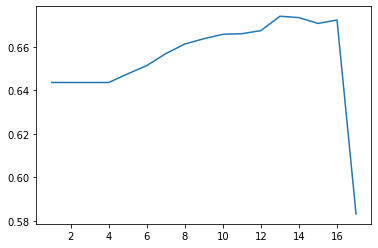

In [123]:
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [124]:
select_index = rfecv.support_
select_feature = train_data.columns[select_index]
print(len(select_feature.values))
print(select_feature)

13
Index(['usd_goal_real_log', 'category_Apps', 'category_Country & Folk',
       'category_Indie Rock', 'category_Shorts', 'category_Tabletop Games',
       'category_Web', 'main_category_Comics', 'main_category_Music',
       'main_category_Theater', 'currency_USD', 'country_US',
       'country_cou_other'],
      dtype='object')


目的変数との相関係数の絶対値が0.06以上の説明変数からステップワイズ法によって選択された特徴量は13個である．<br>
選択された13個の特徴量を用いて重回帰分析を行う．

In [125]:
remove_index = ~rfecv.support_
remove_index = np.insert(remove_index, 0, False)
remove_index = data_dummy_remove.columns[remove_index]
data_mra = data_dummy_remove.drop(remove_index, axis=1)
data_mra.head()

,state,usd_goal_real_log,category_Apps,category_Country & Folk,category_Indie Rock,category_Shorts,category_Tabletop Games,category_Web,main_category_Comics,main_category_Music,main_category_Theater,currency_USD,country_US,country_cou_other
0,0,7.34,0,0,0,0,0,0,0,0,0,0,0,0
1,0,10.31,0,0,0,0,0,0,0,0,0,1,1,0
2,0,10.71,0,0,0,0,0,0,0,0,0,1,1,0
3,0,8.52,0,0,0,0,0,0,0,1,0,1,1,0
4,0,9.88,0,0,0,0,0,0,0,0,0,1,1,0


<AxesSubplot:>

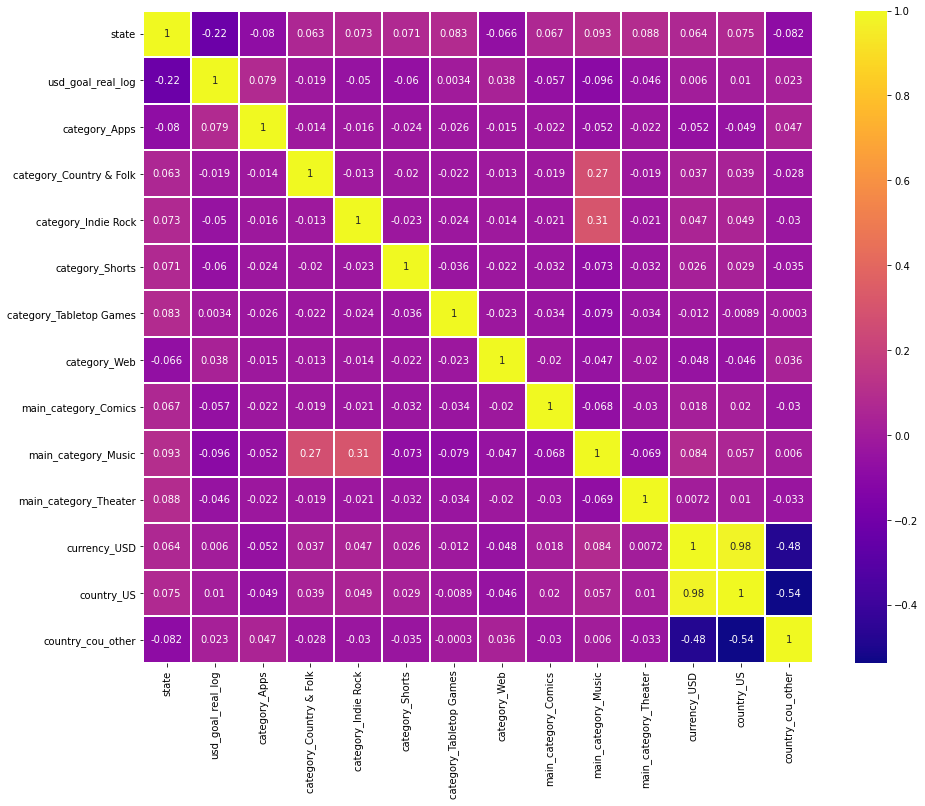

In [126]:
# 各変数の相関係数
plt.figure(figsize=(15, 12))
sns.heatmap(data_mra.corr(), annot=True, linewidths=1, cmap='plasma')

説明変数間の相関係数から
- main_category_Musicとcategory_Country & Folk, category_Indie Rock
- country_USとcurrency_USD, country_cou_other

に関しては相関係数が非常に高く，多重共線性によって学習の妨げになる可能性がある．<br>
1. main_category_Musicとcategory_Country & Folk, category_Indie Rockに関しては，category_Country & Folkとcategory_Indie Rockの相関係数は小さいこと，特徴量をあまり減らしたくないことから，category_Country & Folk, category_Indie Rockの二つを選択する．<br>
1. country_USとcurrency_USDに関しては非常によく似た説明変数であるので，stateとの相関係数が大きいcountry_USを選択する．<br>
country_cou_otherに関してもcountry_USとの相関係数が大きいため選択しない．

In [127]:
# dataから説明変数として用いない変数を消去
data_mra.drop(['main_category_Music', 'currency_USD', 'country_cou_other'], axis=1, inplace=True)

data_mra.head()

,state,usd_goal_real_log,category_Apps,category_Country & Folk,category_Indie Rock,category_Shorts,category_Tabletop Games,category_Web,main_category_Comics,main_category_Theater,country_US
0,0,7.34,0,0,0,0,0,0,0,0,0
1,0,10.31,0,0,0,0,0,0,0,0,1
2,0,10.71,0,0,0,0,0,0,0,0,1
3,0,8.52,0,0,0,0,0,0,0,0,1
4,0,9.88,0,0,0,0,0,0,0,0,1


## 多重共線性の確認

ステップワイズ法を用いて選択した10個の特徴量について多重共線性を確認する．<br>
ここでは多重共線性を測る尺度としてVIFを使用する．<br>
このVIFは以下の計算で求めることができる．
\begin{equation}
VIF = \frac{1}{1 - R^2_{X_j|X_{-j}}}
\end{equation}
ここで$R^2_{X_j|X_{-j}}$は$X_j$を目的変数とし，それ以外の列$X_{-j}$を用いて計算する決定係数である．

In [128]:
data_mra_X = data_mra.iloc[:, 1:]
data_mra_y = data_mra['state']

for cname in data_mra_X.columns:  
    y=data_mra_X[cname]
    X=data_mra_X.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    rsquared = regr.score(X,y)
    print(cname,":" ,1/(1-np.power(rsquared,2)))

usd_goal_real_log : 1.0004056630597944
category_Apps : 1.000128715081155
category_Country & Folk : 1.0000207064091795
category_Indie Rock : 1.0000698551026475
category_Shorts : 1.0001189328524884
category_Tabletop Games : 1.0000458149275182
category_Web : 1.0000368538321682
main_category_Comics : 1.000091630938765
main_category_Theater : 1.0000647060155092
country_US : 1.0001027989851707


VIFは1に近いほど共線形性は弱いことを示すような指標である．<br>
上記のVIFの結果からこれらの特徴量には共線形性はないと考えられる．<br>
よってこれらの変数を用いてモデルの学習を行う．

## まとめ

ここで行った操作をまとめて書き記す．<br>
操作したデータはdata_exp2, data_dummy, data_mra．

- data_exp2 : dataのコピー，stateの数値化とusd_goal_real_logのlog変換を実行
- data_dummy : data_exp2にone-hot encoding操作を実行
- data_mra : data_dummyからステップワイズ法によって選択された特徴量のみのデータ，main_category_Music, currency_USD, country_cou_otherは相関係数が大きいため削除

ここで選択された特徴量はVIFの計算から共線形性はないと考えられる．

# モデルについて

ここでは以下のモデルを用いてクラウドファンディングのstateがsuccessfulかfailedかを予測を行う．<br>
- ロジスティック回帰分析
- SVC
- ランダムフォレスト
- ニューラルネットワーク

今回分析に使用するステップワイズ法によって選択された特徴量は，全て既にスケール変換が済んだ特徴量であるため，改めてスケール変換を行う必要はない．<br>
また今回使用しているデータは約37万程度と大きなデータを使用しているため，ホールドアウト法を用いて汎化性能を評価する．(特にSVCに対して交差検証を行うと数日程度かかることが予想されたため)

In [129]:
# 学習などに使用する特徴量
y = data_mra_y.values
X = data_mra_X.values
X_columns = data_mra_X.columns

# ホールドアウト法による学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# 結果を保持する変数
Summary = {}

In [130]:
def summary(y, y_pred):
    """
    Accuracy, Precision, Recall, F1_score, confusion matrixを一括で出力する関数
    
    Input
    
    y : Correct Label
    y_pred : Predicted Label
    
    
    Output
    
    Accuracy, Precision, Recall, F1_score
    """
    
    # Accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f'Accuracy : {accuracy*100:.2f}%')

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)
    print(f'Precision : {precision[1]*100:.2f}%')
    print(f'Recall : {recall[1]*100:.2f}%')
    print(f'F1-score : {f1_score[1]*100:.2f}')

    # confusion matrix
    conf_mat = confusion_matrix(y, y_pred)
    conf_mat = pd.DataFrame(conf_mat, index=['Label : failed', 'Label : successful'], columns=['Predict : failed', 'Predict : successful'])
    display(conf_mat)
    
    return {'Accuracy' : accuracy, 'Precision' : precision[1], 'Recall' : recall[1], 'F1-score' : f1_score[1]}

## ロジスティック回帰分析

In [131]:
# train
# ロジスティック回帰モデル, L2正則化使用
sgd = SGDClassifier(loss='log', penalty='l2', max_iter=10000, fit_intercept=True, random_state=random_state, tol=1e-3)
sgd.fit(X_train, y_train)


print('train')

# 学習用データのラベル予測
y_pred_train_sgd = sgd.predict(X_train)
summary(y=y_train, y_pred=y_pred_train_sgd)

print('--------------------')

# test
print('test')

# テストデータのラベル予測
y_pred_test_sgd = sgd.predict(X_test)
summary(y=y_test, y_pred=y_pred_test_sgd)

print('--------------------')

# 全体についての評価
print('ALL')

# 学習用データのラベル予測
y_pred_sgd = sgd.predict(X)
Summary['LogisticRegression'] = summary(y=y, y_pred=y_pred_sgd)

train
Accuracy : 66.61%
Precision : 64.51%
Recall : 14.23%
F1-score : 23.32


,Predict : failed,Predict : successful
Label : failed,185034,8396
Label : successful,91995,15264


--------------------
test
Accuracy : 66.54%
Precision : 62.97%
Recall : 14.02%
F1-score : 22.94


,Predict : failed,Predict : successful
Label : failed,46274,2202
Label : successful,22953,3744


--------------------
ALL
Accuracy : 66.60%
Precision : 64.20%
Recall : 14.19%
F1-score : 23.24


,Predict : failed,Predict : successful
Label : failed,231308,10598
Label : successful,114948,19008


ロジスティック回帰の学習データに対する結果とテストデータに対する結果を比較して，モデルが未学習状態にはないと予想される．

## SVC

SVCについてはグリッドサーチによる最適パラメータの探索を実施する．<br>
SVCは正解ラベルが$y \in \{-1, 1\}$である必要があるので，正解ラベルを変更する．

In [132]:
# 学習などに使用する特徴量
y = data_mra_y.values
X = data_mra_X.values
X_columns = data_mra_X.columns

# 正解ラベルをsvc用に-1, 1に変更
y_svc = 2*y-1

# ホールドアウト法による学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y_svc, test_size=test_size, random_state=random_state)

In [133]:
"""
# SVCのグリッドサーチを行った結果，学習に相当な時間を使っても結果が得られなかった
# SVC
svc = SVC(gamma='scale', random_state=random_state)

parameters = {
    'C' : [0.1, 0.01, 0.001],
    'kernel' : ['linear', 'rbf']
}

svc_GS = GridSearchCV(svc, parameters, cv=3)
svc_GS.fit(X_train, y_train)
print(svc_GS.best_params_, svc_GS.best_score_)
"""

"\n# SVCのグリッドサーチを行った結果，学習に相当な時間を使っても結果が得られなかった\n# SVC\nsvc = SVC(gamma='scale', random_state=random_state)\n\nparameters = {\n    'C' : [0.1, 0.01, 0.001],\n    'kernel' : ['linear', 'rbf']\n}\n\nsvc_GS = GridSearchCV(svc, parameters, cv=3)\nsvc_GS.fit(X_train, y_train)\nprint(svc_GS.best_params_, svc_GS.best_score_)\n"

In [134]:
# 学習に5時間程度要する
svc = SVC(C=0.01, kernel='rbf', random_state=random_state)
svc.fit(X_train, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1234, shrinking=True,
    tol=0.001, verbose=False)

In [135]:
# 実行に時間を要する
# predictがボトルネックになっている
print('train')

# 学習用データのラベル予測
y_pred_train_svc = svc.predict(X_train)
summary(y=y_train, y_pred=y_pred_train_svc)

print('--------------------')

# test
print('test')

# テストデータのラベル予測
y_pred_test_svc = svc.predict(X_test)
summary(y=y_test, y_pred=y_pred_test_svc)

print('--------------------')

# 全体についての評価
print('ALL')

# 全データのラベル予測
y_pred_svc = svc.predict(X)
Summary['SVC'] = summary(y=y_svc, y_pred=y_pred_svc)

train
Accuracy : 64.38%
Precision : 73.80%
Recall : 0.23%
F1-score : 0.46


,Predict : failed,Predict : successful
Label : failed,193343,87
Label : successful,107014,245


--------------------
test
Accuracy : 64.54%
Precision : 72.94%
Recall : 0.23%
F1-score : 0.46


,Predict : failed,Predict : successful
Label : failed,48453,23
Label : successful,26635,62


--------------------
ALL
Accuracy : 64.41%
Precision : 73.62%
Recall : 0.23%
F1-score : 0.46


,Predict : failed,Predict : successful
Label : failed,241796,110
Label : successful,133649,307


SVCの学習データに対する結果とテストデータに対する結果を比較して，ほぼ全てのデータにfailedと返すように学習をしてしまったこと (不均衡データの学習がうまくいっていないこと)がわかる．<br>
これを改善するためにCの値を変更することを考えたが，SVCの学習及び推論に非常に時間がかかったため，Cについてグリッドサーチなどを行って性能を改善することは難しいと考え，異なるモデルを試すこととする．

## ランダムフォレスト

In [136]:
# 学習などに使用する特徴量
y = data_mra_y.values
X = data_mra_X.values
X_columns = data_mra_X.columns

# ホールドアウト法による学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

### グリッドサーチを用いた最適なハイパーパラメータの探索

In [137]:
# RandomForest
rf = RandomForestClassifier(random_state=random_state)

# グリッドサーチのパラメータ候補
parameters = {
    'n_estimators' : [5, 10, 50, 100, 200],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 4, 5, 6]
}

rf_GS = GridSearchCV(rf, parameters, cv=3, scoring='accuracy')
rf_GS.fit(X_train, y_train)
print(f'best parametor : {rf_GS.best_params_}')
print(f'best score : {rf_GS.best_score_}:.2f')

best parametor : {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 50}
best score : 0.6689602876989597:.2f


In [138]:
# グリッドサーチから最適と考えられるRandomForestモデル
rf_best = rf_GS.best_estimator_

print('train')

# 学習用データのラベル予測
y_pred_train_rf = rf_best.predict(X_train)
summary(y=y_train, y_pred=y_pred_train_rf)

print('--------------------')

# test
print('test')

# テストデータのラベル予測
y_pred_test_rf = rf_best.predict(X_test)
summary(y=y_test, y_pred=y_pred_test_rf)

print('--------------------')

# 全体についての評価
print('ALL')

# 学習用データのラベル予測
y_pred_rf = sgd.predict(X)
Summary['RandomForestClassifier'] = summary(y=y, y_pred=y_pred_rf)

train
Accuracy : 66.93%
Precision : 66.32%
Recall : 14.81%
F1-score : 24.22


,Predict : failed,Predict : successful
Label : failed,185360,8070
Label : successful,91370,15889


--------------------
test
Accuracy : 66.89%
Precision : 65.25%
Recall : 14.50%
F1-score : 23.73


,Predict : failed,Predict : successful
Label : failed,46414,2062
Label : successful,22826,3871


--------------------
ALL
Accuracy : 66.60%
Precision : 64.20%
Recall : 14.19%
F1-score : 23.24


,Predict : failed,Predict : successful
Label : failed,231308,10598
Label : successful,114948,19008


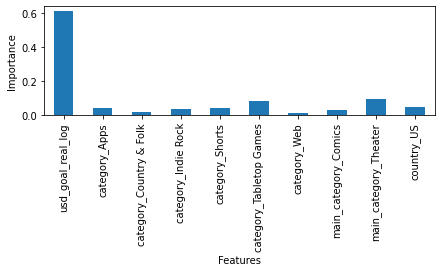

In [139]:
# 説明変数の重要度
pd.DataFrame(rf_best.feature_importances_, index=X_columns).plot.bar(figsize=(7,2), legend=False)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## ニューラルネットワーク

ここではニューラルネットワークを用いて分類を行う．<br>
ニューラルネットワークの構成は以下の通り．
- 4層のニューラルネットワーク
 1. Layer1 : ノード数8 (Dropout使用, DropoutRate=0.1)
 1. Layer2 : ノード数6
 1. Layer3 : ノード数4
 1. 出力層 : ノード数2 (2値分類問題のため)
- optimizer : Adam, LearningRate=0.01
- Epochs : 50
- ミニバッチサイズ : 128


In [140]:
# 学習などに使用する特徴量
y = data_mra['state'].values
X = data_mra_X.values
X_columns = data_mra_X.columns

# ホールドアウト法による学習データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [141]:
# 出力の次元
outputdim_1 = 8
outputdim_2 = 6
outputdim_3 = 4

nn = Sequential()
nn.add(Dense(outputdim_1, activation='relu', input_dim=X_train.shape[1]))
nn.add(Dropout(0.1))
nn.add(Dense(outputdim_2, activation='relu', input_dim=outputdim_1))
nn.add(Dense(outputdim_3, activation='relu', input_dim=outputdim_2))
nn.add(Dense(2, activation='softmax'))

In [142]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 10        
Total params: 180
Trainable params: 180
Non-trainable params: 0
_________________________________________________________________


In [143]:
# early_stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [144]:
nn.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

In [145]:
history = nn.fit(X_train, y_train_oh,
                    batch_size=128,
                    epochs=50,
                    verbose=1,
                   validation_data=(X_test, y_test_oh),
                    # callbacks=[early_stopping]
                   )

Epoch 1/50
2350/2350 [==============================] - 2s 853us/step - loss: 0.6127 - accuracy: 0.6667 - val_loss: 0.6099 - val_accuracy: 0.6676
Epoch 2/50
2350/2350 [==============================] - 2s 861us/step - loss: 0.6064 - accuracy: 0.6704 - val_loss: 0.6019 - val_accuracy: 0.6746
Epoch 3/50
2350/2350 [==============================] - 2s 777us/step - loss: 0.6048 - accuracy: 0.6712 - val_loss: 0.6028 - val_accuracy: 0.6728
Epoch 4/50
2350/2350 [==============================] - 2s 804us/step - loss: 0.6043 - accuracy: 0.6719 - val_loss: 0.6020 - val_accuracy: 0.6748
Epoch 5/50
2350/2350 [==============================] - 2s 737us/step - loss: 0.6034 - accuracy: 0.6723 - val_loss: 0.6021 - val_accuracy: 0.6755
Epoch 6/50
2350/2350 [==============================] - 2s 806us/step - loss: 0.6032 - accuracy: 0.6726 - val_loss: 0.6016 - val_accuracy: 0.6738
Epoch 7/50
2350/2350 [==============================] - 2s 744us/step - loss: 0.6031 - accuracy: 0.6723 - val_loss: 0.6004 -

In [147]:
score = nn.evaluate(X_test, y_test_oh, verbose=0)
print(f'Test Loss : {score[0]}')
print(f'Test Accuracy : {score[1]}')

Test Loss : 0.6018043160438538
Test Accuracy : 0.6752158403396606


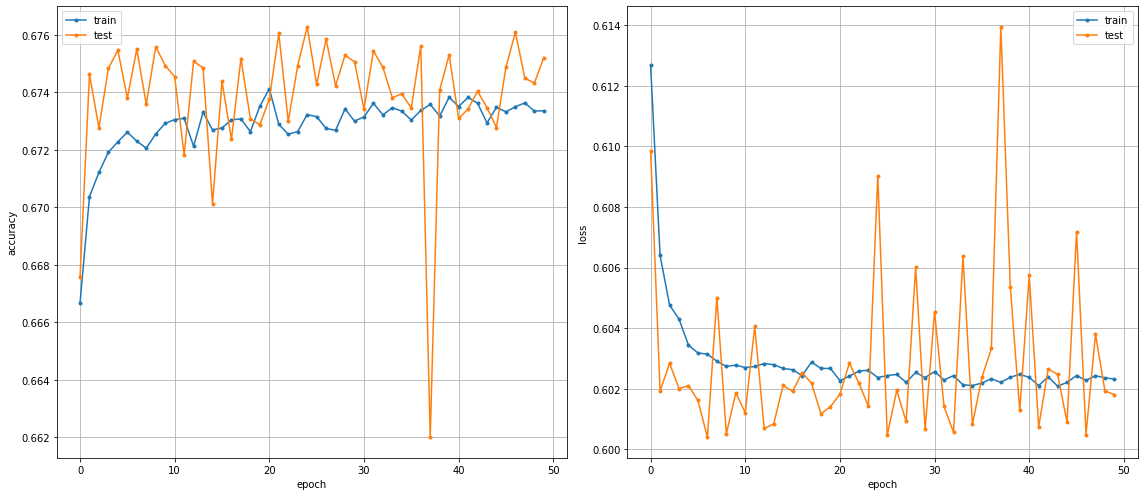

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# plot(accuracy)
ax[0].plot(history.history['accuracy'], marker='.', label='train')
ax[0].plot(history.history['val_accuracy'], marker='.', label='test')
ax[0].grid()
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(loc='best')

# plot(loss)
ax[1].plot(history.history['loss'], marker='.', label='train')
ax[1].plot(history.history['val_loss'], marker='.', label='test')
ax[1].grid()
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [149]:
print('train')

# 学習用データのラベル予測
y_pred_train_nn = np.argmax(nn.predict(X_train), axis=1)
summary(y=y_train, y_pred=y_pred_train_nn)

print('--------------------')

# test
print('test')

# テストデータのラベル予測
y_pred_test_nn = np.argmax(nn.predict(X_test), axis=1)
summary(y=y_test, y_pred=y_pred_test_nn)

print('--------------------')

# 全体についての評価
print('ALL')

# 学習用データのラベル予測
y_pred_nn = np.argmax(nn.predict(X), axis=1)
Summary['NeuralNetwork'] = summary(y=y, y_pred=y_pred_nn)

train
Accuracy : 67.41%
Precision : 60.67%
Recall : 24.60%
F1-score : 35.00


,Predict : failed,Predict : successful
Label : failed,176327,17103
Label : successful,80877,26382


--------------------
test
Accuracy : 67.52%
Precision : 60.49%
Recall : 24.65%
F1-score : 35.03


,Predict : failed,Predict : successful
Label : failed,44177,4299
Label : successful,20116,6581


--------------------
ALL
Accuracy : 67.44%
Precision : 60.63%
Recall : 24.61%
F1-score : 35.01


,Predict : failed,Predict : successful
Label : failed,220504,21402
Label : successful,100993,32963


In [150]:
# モデルの保存
nn.save('./Model/NN.h5')

# 結果のまとめ

In [151]:
print('以下は全て%表示')
Summary_columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
Summary_T = pd.DataFrame(Summary).T
Summary_sorted = Summary_T[Summary_columns].sort_values(by=['Accuracy'], ascending=False)
display(Summary_sorted*100)

以下は全て%表示


,Accuracy,Precision,Recall,F1-score
NeuralNetwork,67.44,60.63,24.61,35.01
LogisticRegression,66.60,64.20,14.19,23.24
RandomForestClassifier,66.60,64.20,14.19,23.24
SVC,64.41,73.62,0.23,0.46


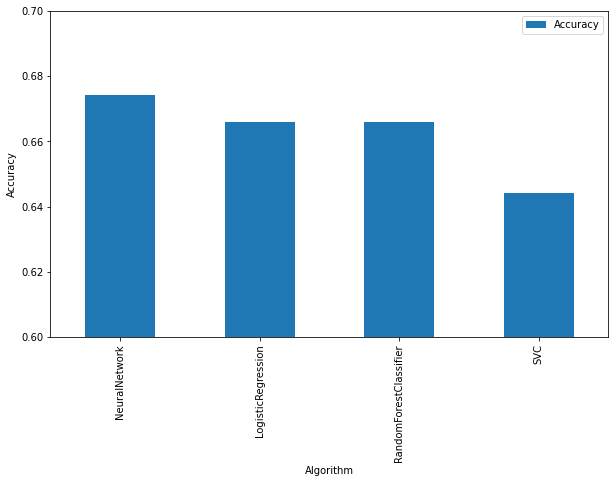

In [152]:
Summary_acc = Summary_sorted[['Accuracy']]
Summary_acc.plot.bar(figsize=(10,6))
plt.ylabel("Accuracy")
plt.xlabel("Algorithm")
plt.ylim([0.6, 0.7])
plt.show()

これらの結果から，今回使用したkickstarterのデータセットにおいてクラウドファンディングが成功するかどうかを最もよく予想できたモデルはニューラルネットワークを利用したモデルであった．<br>
しかしどのモデルもAccuracyに大きな違いはなく66%程度であったが，Recallが小さい，つまり失敗する人をうまく見抜けないようなモデルになってしまった部分については改善の余地がある．<br>
改善の方針としては
- より相関係数の高い特徴量を見つけ出す
- モデルに入力する特徴量を増やす

などが考えられる．<br>

# 本課題を通して

本課題を通していくつかのことを学ぶことができた．<br>

まず一つ目に，前処理の大変さ及び重要さを改めて感じた．<br>
本課題に取り組む中で，必要な前処理を怠ったが故にモデルが正常に学習できなかったり，長時間学習を行って学習結果をまとめる際にエラーが出てしまったりということに何度も見舞われた．
このことから前処理はより慎重に行うべきであるということを学んだ．<br>

二つ目に，変数名はわかりやすくつけるべきであることを学んだ．<br>
本課題のなかでpandasのDataFrameには全てdata_xxというように，データの中身が一目でわかるように名前を付けたつもりであったが，このデータはどの処理を行ったデータであるのかがわからなくなることが何度かあった．<br>
今回はそれを解決するために，各章の最後にその章で操作したデータと操作内容をメモするようにしたが，今後はよりわかりやすいような変数名をつけることを心がけ，PEP8も意識してコードを書くことができるように勉強を続けたいと思う．